##### Problem
The problem at hand is a decrease in customer satisfaction, leading to concerns about customer retention and loyalty. Amazon has observed a decline in customer satisfaction scores, an increase in negative customer feedback. The goal of this data science project is to understand the root causes of the declining customer satisfaction and develop actionable insights and recommendations to address the issue effectively.

##### Business Objectives

- Personalize recommendations of product to increase customer engagement and sales.
- Optimize Customer Purchasing Experience by filtering out fake reviews


##### Research Objectives



- To develop a model to classify fake or manipulated reviews within the dataset 

- To investigate the impact of incorporating review text, on the performance of the product recommendation system.


In [1]:
#Import Libraries
import time
from pyspark.sql import SparkSession,DataFrame
import pandas as pd
from functools import reduce
from pyspark.sql.functions import rand
from pyspark.sql.functions import *
import pyspark.sql.functions as f
from datetime import datetime
from pyspark.sql.types import StringType,FloatType,TimestampType,DateType,ArrayType,IntegerType
import re
import nltk
from nltk.corpus import stopwords,wordnet
from nltk.tokenize import word_tokenize
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, Tokenizer,CountVectorizer,IDF\
,HashingTF,NGram,BucketedRandomProjectionLSH,Normalizer
import seaborn as sns
import matplotlib.pyplot as plt
import math    
from textblob import TextBlob
import string
from bs4 import BeautifulSoup
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import spacy
from scipy.stats import pointbiserialr
import plotly.express as px
from pyspark.conf import SparkConf
import wordcloud 
from  pyspark.ml import PipelineModel
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder,TrainValidationSplit
from pyspark.ml.evaluation import RegressionEvaluator,BinaryClassificationEvaluator,MulticlassClassificationEvaluator,\
ClusteringEvaluator
from pyspark.ml.clustering import KMeans,BisectingKMeans,KMeansModel,BisectingKMeansModel
from pyspark.ml.classification import NaiveBayes,LinearSVC,RandomForestClassifier,LogisticRegression,DecisionTreeClassifier,\
LinearSVCModel,DecisionTreeClassificationModel
from pyspark.ml.recommendation import ALS,ALSModel
from pyspark.ml import Transformer
from pyspark.ml.param import Param, Params
from pyspark.ml.param.shared import HasInputCol, HasOutputCol,TypeConverters
from pyspark.ml.util import DefaultParamsWritable, DefaultParamsReadable
from pyspark import keyword_only
from pyspark.ml.linalg import Vectors, VectorUDT
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from scipy.sparse import coo_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from pyspark.ml.feature import StringIndexer,IndexToString,MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler,StandardScaler,PCA
from pyspark.ml.feature import Normalizer
from pyspark.mllib.linalg.distributed import CoordinateMatrix
import multiprocessing
from textblob import Word
import numpy as np
from collections import Counter
import plotly.graph_objects as go

In [3]:
# Create a SparkSession
spark = SparkSession.builder.appName("amazonapp").getOrCreate()

In [2]:


# Read the data from a tab-separated values (TSV) file located in a Google Cloud Storage (GCS) bucket

# The data contains us customer product reviews from Amazon and is stored in the file amazonReviews1M.tsv

#This dataset is a sample of a much larger dataset from kaggle which contains over 100 million rows 
#(https://www.kaggle.com/datasets/cynthiarempel/amazon-us-customer-reviews-dataset)

#The dataset is a random sample of the original dataset
df = spark.read.parquet(r"C:\Users\dn10657\source\repos\Capstone\dataset\amazonReviewsparquet1M")

In [3]:
#checking the size of the dataset
df.count()

1033363

In [4]:
df.show()

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+--------------------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|         review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+--------------------+
|         US|   26524369|R3HH81BIQ3ZZE1|B00SETTZGE|      10327631|RUGGED & DAPPER –...|          Beauty|          3|            6|         11|   N|                Y|Good/great face w...|The face wash is ...|2015-04-25T00:00:...|
|         US|   26920430|R2R0NREZG6WG2V|B006XY3Y1Y|      57006252|Tretinoin Microsp.

In [5]:
#The data contains customer product reviews from Amazon with each review having a class column where "0" 
#indicates not spam and "1" indicates spam reviews.

#dataset was sourced from https://www.kaggle.com/datasets/naveedhn/amazon-product-review-spam-and-non-spam
spam_df = spark.read.parquet(r"C:\Users\dn10657\source\repos\Capstone\dataset\spam_dataset_parquet") 


In [6]:
spam_df.limit(5).toPandas()

,_id,asin,category,class,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,"(5a132773741a2384e84b883e,)",B000AAYBZ0,Sports_and_Outdoors,1.0,"[0, 0]",4.0,I advise you to read all of the reviews of the...,"03 31, 2009",A34IJACMU8C3IM,"Rob W. ""Sounddude""",Good Seat Bag For The Money!,1238457600
1,"(5a132773741a2384e84b884a,)",B000AAYBZ0,Sports_and_Outdoors,0.0,"[2, 14]",1.0,I can't figure the thing out. How does it mo...,"04 21, 2008",AM779PE0NTAEK,Thomas C. Ardoline,stuck riding,1208736000
2,"(5a132773741a2384e84b886a,)",B000AAYC5O,Sports_and_Outdoors,0.0,"[2, 2]",1.0,Made of cheap plastic and will not support the...,"08 25, 2012",A2FU8Y7IE3K84K,Tom S,Not worth the money,1345852800
3,"(5a132773741a2384e84b8874,)",B000AAYC6I,Sports_and_Outdoors,1.0,"[1, 1]",5.0,Easy to put together.Sturdy.Great for the gara...,"06 19, 2011",A13E8WQH3FFQL0,honeycombcandles,Bike Rack,1308441600
4,"(5a132773741a2384e84b888a,)",B000AAYC72,Sports_and_Outdoors,1.0,"[4, 4]",4.0,I read the reviews about this product before I...,"11 19, 2010",A3ED6RMQAUMVYR,echapman,"Works with bolt ons, fairly quiet, and stable",1290124800


In [7]:
#checking the size of the dataset
spam_df.count()

1010113

In [8]:
#taking sample of dataset to see what data is like
spam_df.limit(5).toPandas()

,_id,asin,category,class,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,"(5a132773741a2384e84b883e,)",B000AAYBZ0,Sports_and_Outdoors,1.0,"[0, 0]",4.0,I advise you to read all of the reviews of the...,"03 31, 2009",A34IJACMU8C3IM,"Rob W. ""Sounddude""",Good Seat Bag For The Money!,1238457600
1,"(5a132773741a2384e84b884a,)",B000AAYBZ0,Sports_and_Outdoors,0.0,"[2, 14]",1.0,I can't figure the thing out. How does it mo...,"04 21, 2008",AM779PE0NTAEK,Thomas C. Ardoline,stuck riding,1208736000
2,"(5a132773741a2384e84b886a,)",B000AAYC5O,Sports_and_Outdoors,0.0,"[2, 2]",1.0,Made of cheap plastic and will not support the...,"08 25, 2012",A2FU8Y7IE3K84K,Tom S,Not worth the money,1345852800
3,"(5a132773741a2384e84b8874,)",B000AAYC6I,Sports_and_Outdoors,1.0,"[1, 1]",5.0,Easy to put together.Sturdy.Great for the gara...,"06 19, 2011",A13E8WQH3FFQL0,honeycombcandles,Bike Rack,1308441600
4,"(5a132773741a2384e84b888a,)",B000AAYC72,Sports_and_Outdoors,1.0,"[4, 4]",4.0,I read the reviews about this product before I...,"11 19, 2010",A3ED6RMQAUMVYR,echapman,"Works with bolt ons, fairly quiet, and stable",1290124800


In [9]:
spam_df.limit(5).toPandas()

,_id,asin,category,class,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,"(5a132773741a2384e84b883e,)",B000AAYBZ0,Sports_and_Outdoors,1.0,"[0, 0]",4.0,I advise you to read all of the reviews of the...,"03 31, 2009",A34IJACMU8C3IM,"Rob W. ""Sounddude""",Good Seat Bag For The Money!,1238457600
1,"(5a132773741a2384e84b884a,)",B000AAYBZ0,Sports_and_Outdoors,0.0,"[2, 14]",1.0,I can't figure the thing out. How does it mo...,"04 21, 2008",AM779PE0NTAEK,Thomas C. Ardoline,stuck riding,1208736000
2,"(5a132773741a2384e84b886a,)",B000AAYC5O,Sports_and_Outdoors,0.0,"[2, 2]",1.0,Made of cheap plastic and will not support the...,"08 25, 2012",A2FU8Y7IE3K84K,Tom S,Not worth the money,1345852800
3,"(5a132773741a2384e84b8874,)",B000AAYC6I,Sports_and_Outdoors,1.0,"[1, 1]",5.0,Easy to put together.Sturdy.Great for the gara...,"06 19, 2011",A13E8WQH3FFQL0,honeycombcandles,Bike Rack,1308441600
4,"(5a132773741a2384e84b888a,)",B000AAYC72,Sports_and_Outdoors,1.0,"[4, 4]",4.0,I read the reviews about this product before I...,"11 19, 2010",A3ED6RMQAUMVYR,echapman,"Works with bolt ons, fairly quiet, and stable",1290124800


In [10]:
#function that gets the shape of data set (number of rows and columns)
def shape(df):
    # Get the number of rows
    num_rows = df.count()

    # Get the number of columns
    num_cols = len(df.columns)

    # Print the shape of the DataFrame
    print(f"Shape: ({num_rows}, {num_cols})")

In [11]:
shape(spam_df)

Shape: (1010113, 12)


In [12]:
shape(df)

Shape: (1033363, 15)


In [13]:
df.limit(5).toPandas()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,26524369,R3HH81BIQ3ZZE1,B00SETTZGE,10327631,RUGGED & DAPPER – Facial Cleanser for Men – 8 ...,Beauty,3,6,11,N,Y,"Good/great face wash, poor bottle design",The face wash is great. My skin feels differen...,2015-04-25T00:00:00.000Z
1,US,26920430,R2R0NREZG6WG2V,B006XY3Y1Y,57006252,Tretinoin Microsphere 0.1% USP w/w 20g,Beauty,4,1,1,N,Y,Works Great,"Works well on uneven skin tone, melasma, sun s...",2012-06-08T00:00:00.000Z
2,US,26523163,R1ZYSPZ3LWHVM4,B008QYE40Y,966404562,Sleek i-Divine Storm Palette Mineral based Eye...,Beauty,5,1,1,N,Y,Wonderful palette!,This eyeshadow palette is wonderful! The color...,2013-05-26T00:00:00.000Z
3,US,9963368,R3VXVN0I0E1PIV,B004VFXVJW,806462967,The Shave Well Company a TRULY FOG FREE Shower...,Beauty,5,1,1,N,Y,BEST MIRROR EVER,My husband has a very rough beard and therefor...,2012-02-22T00:00:00.000Z
4,US,2662502,R2H4PHUSEOH4T8,B0009OAHQY,591505715,Claiborne Cologne by Liz Claiborne for men Col...,Beauty,5,1,1,N,Y,Five Stars,Love it,2014-11-13T00:00:00.000Z


In [14]:
#shows missing values for all columns
def showMissingValues(df):
    print('\nMissing values:')
    # Iterate over each column and print the name and count of missing values
    for c in df.columns:
        null_count = df.select(count(when(col(c).isNull(), c))).collect()[0][0]    
        print("{}: {}".format(c, null_count))

In [15]:
#shows missing values for specific column
def showMissingValuesByCol(colName,df):
    print('\nMissing values:')
    null_count = df.select(count(when(col(colName).isNull(),colName))).collect()[0][0]    
    print("{}: {}".format(colName, null_count))

In [16]:
#shows rows where specific column is null
def showPandasDFOfNullRows(colName, df, limit):
    null_rows = df.filter(isnull(df[colName]))
    random_null_rows = null_rows.orderBy(rand()).limit(limit)
    return random_null_rows.toPandas()

In [17]:
showMissingValues(df)


Missing values:
marketplace: 0
customer_id: 0
review_id: 0
product_id: 0
product_parent: 0
product_title: 0
product_category: 9
star_rating: 9
helpful_votes: 9
total_votes: 9
vine: 9
verified_purchase: 9
review_headline: 69
review_body: 117
review_date: 73


In [18]:
showMissingValues(spam_df)


Missing values:
_id: 0
asin: 0
category: 0
class: 0
helpful: 0
overall: 0
reviewText: 0
reviewTime: 0
reviewerID: 0
reviewerName: 8066
summary: 0
unixReviewTime: 0


In [19]:
#gets all the column names in dataset
spam_df.columns

['_id',
 'asin',
 'category',
 'class',
 'helpful',
 'overall',
 'reviewText',
 'reviewTime',
 'reviewerID',
 'reviewerName',
 'summary',
 'unixReviewTime']

In [20]:
#gets all the column names in dataset
df.columns

['marketplace',
 'customer_id',
 'review_id',
 'product_id',
 'product_parent',
 'product_title',
 'product_category',
 'star_rating',
 'helpful_votes',
 'total_votes',
 'vine',
 'verified_purchase',
 'review_headline',
 'review_body',
 'review_date']

In [21]:
# Check the data types
print('Data types:')
print(df.dtypes)



Data types:
[('marketplace', 'string'), ('customer_id', 'string'), ('review_id', 'string'), ('product_id', 'string'), ('product_parent', 'string'), ('product_title', 'string'), ('product_category', 'string'), ('star_rating', 'string'), ('helpful_votes', 'string'), ('total_votes', 'string'), ('vine', 'string'), ('verified_purchase', 'string'), ('review_headline', 'string'), ('review_body', 'string'), ('review_date', 'string')]


In [22]:
# Check the data types
print('Data types:')
print(spam_df.dtypes)

Data types:
[('_id', 'struct<$oid:string>'), ('asin', 'string'), ('category', 'string'), ('class', 'double'), ('helpful', 'array<bigint>'), ('overall', 'double'), ('reviewText', 'string'), ('reviewTime', 'string'), ('reviewerID', 'string'), ('reviewerName', 'string'), ('summary', 'string'), ('unixReviewTime', 'bigint')]


In [23]:
df.printSchema()

root
 |-- marketplace: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: string (nullable = true)
 |-- product_title: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- star_rating: string (nullable = true)
 |-- helpful_votes: string (nullable = true)
 |-- total_votes: string (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: string (nullable = true)



In [24]:
spam_df.printSchema()


root
 |-- _id: struct (nullable = true)
 |    |-- $oid: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- category: string (nullable = true)
 |-- class: double (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)



In [25]:
# Use describe() to get summary statistics
summary = df.describe()

# Show the summary
summary.select("summary","star_rating","helpful_votes","total_votes").toPandas()

,summary,star_rating,helpful_votes,total_votes
0,count,1033354,1033354,1033354
1,mean,4.15050505441504,2.16458541796906,2.8719161100648956
2,stddev,1.305044384231812,21.947333910851263,23.990776655808123
3,min,1,0,0
4,max,5,993,99


In [26]:
# Use describe() to get summary statistics
summary = spam_df.select("class","overall").describe()

# Show the summary
summary.toPandas()
#summary.show()

,summary,class,overall
0,count,1010113,1010113
1,mean,0.7775536004387628,4.1291528769553505
2,stddev,0.415889612897432,1.2905134894886963
3,min,0.0,1.0
4,max,1.0,5.0


**Data Exploration Amazon Spam Reviews Dataset**

In [27]:
#gets the count for each unique values in column
spam_df.groupBy('class').count().orderBy('count').show()

+-----+------+
|class| count|
+-----+------+
|  0.0|224696|
|  1.0|785417|
+-----+------+



In [28]:
spam_df.groupBy('reviewText').count().orderBy('count').show()

+--------------------+-----+
|          reviewText|count|
+--------------------+-----+
|I use this for ai...|    1|
|!!!!! The keyboar...|    1|
|!!! Excellent Wat...|    1|
|"BLIP is the TV t...|    1|
|"50 feet Ethernet...|    1|
|"Corel Paint-It P...|    1|
|!!!! Buy a Sony M...|    1|
|"Delightful" seem...|    1|
|!!!Update!!! This...|    1|
|"Effortless setup...|    1|
|!WARNING:Sony BDP...|    1|
|"FansEdge seller,...|    1|
|"A friend told me...|    1|
|"Great seller and...|    1|
|" I like em, what...|    1|
|"I got the Steel ...|    1|
|These are great f...|    1|
|"I love you Princ...|    1|
|" I received a fr...|    1|
|"I was skeptical ...|    1|
+--------------------+-----+
only showing top 20 rows



In [29]:
spam_df.groupBy('reviewerID').count().orderBy('count').show()

+--------------+-----+
|    reviewerID|count|
+--------------+-----+
|A2FRTWIOGB4KIG|    1|
|A2VCX95KY7PK7C|    1|
|A1LKZUS72K8V23|    1|
|A3JTOZ0RNN1R78|    1|
|A2203G8MY0YGYL|    1|
| ASPLZKADV8K7M|    1|
|A2HZIIMZO7ESQ5|    1|
| A7IEF296HAZRI|    1|
| ATFPWTTBR2JRN|    1|
|A243XWW3UZD7MN|    1|
| AUPX5H1RK5C4R|    1|
|A2YUZUFD87ZNX0|    1|
|A1825S8K0K9UJA|    1|
|A2ET11HS9UYSQP|    1|
|A37BOA4UAFAUFW|    1|
|A39GDKGADFO40R|    1|
| AS6DHVI9N9EXI|    1|
|A2GXB6YQLID8UK|    1|
|A29TD8UYQNHCH3|    1|
|A2F1230OJTJ94Y|    1|
+--------------+-----+
only showing top 20 rows



In [30]:
spam_df.groupBy('asin').count().orderBy('count').show()

+----------+-----+
|      asin|count|
+----------+-----+
|B000LQNIXY|    1|
|B0014BPPM2|    1|
|B0015G7QCS|    1|
|B001RIF9PK|    1|
|B000X16VU4|    1|
|B00169O4JC|    1|
|B001GX6JK0|    1|
|B000BJ1LIK|    1|
|B000K9CA0Y|    1|
|B0016OVU58|    1|
|B00162LT4M|    1|
|B000C9PLL2|    1|
|B000WIH0NU|    1|
|B0019T0EVQ|    1|
|B000LG684U|    1|
|B000FKBOKK|    1|
|B000N8OD20|    1|
|B001ASDHRE|    1|
|B0017RF6UE|    1|
|B000H7L3ZC|    1|
+----------+-----+
only showing top 20 rows



**Data Exploration Amazon Product Reviews Dataset**

In [31]:
df.groupBy('customer_id').count().orderBy('count').show()

+-----------+-----+
|customer_id|count|
+-----------+-----+
|   35229388|    1|
|   19618156|    1|
|   31377924|    1|
|    8425065|    1|
|    2613168|    1|
|   25453326|    1|
|   25194391|    1|
|   51932047|    1|
|   13901876|    1|
|   22944765|    1|
|   45725405|    1|
|   18672144|    1|
|   24795556|    1|
|   11599168|    1|
|   15357962|    1|
|   52218773|    1|
|   15483370|    1|
|   30772724|    1|
|   12972211|    1|
|   13059747|    1|
+-----------+-----+
only showing top 20 rows



In [32]:
df.groupBy('review_id').count().orderBy('count').show()

+--------------+-----+
|     review_id|count|
+--------------+-----+
|R20H91ER31YK8S|    1|
|R1XE4R1YAPKILJ|    1|
|R3O3K0CXSG370J|    1|
| RO6LC2Z6DAORJ|    1|
| RWNP0H4WGHPH6|    1|
|R1M43C7PDZM8PG|    1|
| RYOYE97KOAT7G|    1|
|R3PLGG2UZOT5EI|    1|
| RGTD67PHVHI6L|    1|
|R1AC5UYY5SEGJD|    1|
| RTGMEMFSXLG7G|    1|
|R13AGD4IPHIU1N|    1|
|R1Q33XLH2GLPN8|    1|
|R36A8ZHW5Q4AGM|    1|
| RYQ2VJMVICG1X|    1|
|R3RETKT9LIF9CA|    1|
|R2LDOSM48FT6IP|    1|
|R2G0QRN4H8GBUQ|    1|
|R3E0ACXJMSVIF4|    1|
|R3FHG0KY8RI5E3|    1|
+--------------+-----+
only showing top 20 rows



In [33]:
df.groupBy('product_parent').count().orderBy('count').show()

+--------------+-----+
|product_parent|count|
+--------------+-----+
|     934820841|    1|
|     850649988|    1|
|     221209199|    1|
|     964534279|    1|
|     988112704|    1|
|     741161039|    1|
|      74916774|    1|
|     952688148|    1|
|     486824394|    1|
|      79363223|    1|
|     107799824|    1|
|     215108798|    1|
|     808433344|    1|
|     856679767|    1|
|     302060972|    1|
|     976529650|    1|
|     122051494|    1|
|     943171986|    1|
|     662035716|    1|
|     805940798|    1|
+--------------+-----+
only showing top 20 rows



In [34]:
df.groupBy('product_title').count().orderBy('count').show()

+--------------------+-----+
|       product_title|count|
+--------------------+-----+
|Porsche Design Po...|    1|
|Goody Simple Styl...|    1|
|L'Oreal Lash Boos...|    1|
|Caldwell Tack Dri...|    1|
|The History of Wh...|    1|
|Kemi All Natural ...|    1|
|Aquafresh Maximum...|    1|
|Raw Unrefined Ext...|    1|
|Thinksport Kid's ...|    1|
|NCAA Arkansas Sta...|    1|
|Prive Root Amplif...|    1|
|Synergy Tan BROWN...|    1|
|NcSTAR 3 - 9x40E ...|    1|
|Man Utd Fleece Bl...|    1|
|8 Oz Cocojojo Pur...|    1|
|Women Fashion Cut...|    1|
|St Ives Swiss For...|    1|
|Pure Instinct sex...|    1|
|Maybelline New Yo...|    1|
|Majestic Pure Vit...|    1|
+--------------------+-----+
only showing top 20 rows



In [35]:
df.groupBy('product_category').count().orderBy('count').show()

+--------------------+-----+
|    product_category|count|
+--------------------+-----+
|     Lawn and Garden|    2|
|                Home|    6|
|                null|    9|
|             Kitchen|   11|
|    Home Improvement|   11|
|  Home Entertainment|  160|
|Personal_Care_App...|12765|
|    Major Appliances|14610|
|    Digital_Software|15189|
|  Mobile_Electronics|15795|
| Digital_Video_Games|21646|
|           Gift Card|22315|
|          Automotive|29750|
|         Electronics|29809|
| Musical Instruments|29876|
|            Software|29886|
|             Grocery|29907|
|             Watches|29931|
|             Apparel|29947|
|            Outdoors|29974|
+--------------------+-----+
only showing top 20 rows



In [36]:
df.groupBy('star_rating').count().orderBy('count').show()

+-----------+------+
|star_rating| count|
+-----------+------+
|       null|     9|
|          2| 51764|
|          3| 81776|
|          1| 96141|
|          4|174421|
|          5|629252|
+-----------+------+



In [37]:
df.groupBy('helpful_votes').count().orderBy('count').show()

+-------------+-----+
|helpful_votes|count|
+-------------+-----+
|          519|    1|
|          272|    1|
|          328|    1|
|          342|    1|
|          570|    1|
|          357|    1|
|         1559|    1|
|          211|    1|
|          560|    1|
|          698|    1|
|          517|    1|
|         1823|    1|
|          723|    1|
|         3212|    1|
|          482|    1|
|          426|    1|
|          387|    1|
|          664|    1|
|          390|    1|
|          323|    1|
+-------------+-----+
only showing top 20 rows



In [38]:
df.groupBy('total_votes').count().orderBy('count').show()

+-----------+-----+
|total_votes|count|
+-----------+-----+
|        571|    1|
|        719|    1|
|        409|    1|
|        749|    1|
|        969|    1|
|       1943|    1|
|       1086|    1|
|        443|    1|
|        191|    1|
|       1228|    1|
|       1586|    1|
|        593|    1|
|        919|    1|
|       3305|    1|
|        348|    1|
|       1580|    1|
|        782|    1|
|        437|    1|
|        423|    1|
|        375|    1|
+-----------+-----+
only showing top 20 rows



In [39]:
df.groupBy('vine').count().orderBy('count').show()

+----+-------+
|vine|  count|
+----+-------+
|null|      9|
|   Y|   3600|
|   N|1029754|
+----+-------+



In [40]:
df.groupBy('verified_purchase').count().orderBy('count').show()

+-----------------+------+
|verified_purchase| count|
+-----------------+------+
|             null|     9|
|                N|237116|
|                Y|796238|
+-----------------+------+



In [41]:
df.groupBy('review_headline').count().orderBy('count').show()

+--------------------+-----+
|     review_headline|count|
+--------------------+-----+
|     Loads of curls!|    1|
| Love this hair mask|    1|
|Vivica Fox-H218 1...|    1|
|    Good quality/fit|    1|
|Great Razor for t...|    1|
|Just the Part needed|    1|
|Compared to Howar...|    1|
|New Lube and Sizi...|    1|
|  Saves my mani/pedi|    1|
|          SO Good!!!|    1|
|I like to let it ...|    1|
|:( i had no luck ...|    1|
|       Fishing Dummy|    1|
|Best bar soap I h...|    1|
|                 aha|    1|
|Houge Stock and F...|    1|
|Hydrates nails an...|    1|
|... owned a coupl...|    1|
|This is a great O...|    1|
|Top Quality and p...|    1|
+--------------------+-----+
only showing top 20 rows



In [42]:
df.groupBy('review_body').count().orderBy('count').show()

+--------------------+-----+
|         review_body|count|
+--------------------+-----+
|I have been very ...|    1|
|This product was ...|    1|
|They are a little...|    1|
|Fits great. Love ...|    1|
|I am a man in my ...|    1|
|This is just what...|    1|
|I purchased the T...|    1|
|Honestly, the ori...|    1|
|The aroma of FLOW...|    1|
|Didnt do its job....|    1|
|This shampoo is t...|    1|
|I do not have sca...|    1|
|Very nice product...|    1|
|This Product smel...|    1|
|This lotion is fa...|    1|
|Great brushes esp...|    1|
|This was one of m...|    1|
|I got this becaus...|    1|
|Works great for m...|    1|
|I have used sleep...|    1|
+--------------------+-----+
only showing top 20 rows



In [43]:
df.groupBy('review_date').count().orderBy('count').show()

+--------------------+-----+
|         review_date|count|
+--------------------+-----+
|1997-12-30T00:00:...|    1|
|1997-12-06T00:00:...|    1|
|1996-06-05T00:00:...|    1|
|1996-09-22T00:00:...|    1|
|1997-08-30T00:00:...|    1|
|1997-12-14T00:00:...|    1|
|1997-06-09T00:00:...|    1|
|1997-01-10T00:00:...|    1|
|1997-11-25T00:00:...|    1|
|1998-01-02T00:00:...|    1|
|1996-12-21T00:00:...|    1|
|1996-11-12T00:00:...|    1|
|1996-05-25T00:00:...|    1|
|1996-10-06T00:00:...|    1|
|1996-08-23T00:00:...|    1|
|1997-11-13T00:00:...|    1|
|1997-06-30T00:00:...|    1|
|1997-02-02T00:00:...|    1|
|1998-03-26T00:00:...|    1|
|1997-11-06T00:00:...|    1|
+--------------------+-----+
only showing top 20 rows



### Handling data types and missing values Amazon Product Reviews Dataset 

In [44]:
#selecting specific columns which are supposed to be applicable to project
spam_df=spam_df.select(col("class"),col("reviewText"),col("reviewTime"),col("asin"),col("reviewerID"))

In [45]:
spam_df.limit(5).toPandas()

,class,reviewText,reviewTime,asin,reviewerID
0,1.0,I advise you to read all of the reviews of the...,"03 31, 2009",B000AAYBZ0,A34IJACMU8C3IM
1,0.0,I can't figure the thing out. How does it mo...,"04 21, 2008",B000AAYBZ0,AM779PE0NTAEK
2,0.0,Made of cheap plastic and will not support the...,"08 25, 2012",B000AAYC5O,A2FU8Y7IE3K84K
3,1.0,Easy to put together.Sturdy.Great for the gara...,"06 19, 2011",B000AAYC6I,A13E8WQH3FFQL0
4,1.0,I read the reviews about this product before I...,"11 19, 2010",B000AAYC72,A3ED6RMQAUMVYR


#### product_category

In [46]:
showPandasDFOfNullRows("product_category", df, 10)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,34077068,R5QMKUM3C1KO3,B0082CXEI8,661176068,"Blue Sea Systems BelowDeck Panels, Dual USB Ch...",None,None,None,None,None,None,None,None,None
1,US,5883076,R1B99YM5JYBAUI,B00CLVNIE6,6211165,Fonus 3.5mm White Premium Coiled Car Stereo Au...,None,None,None,None,None,None,None,None,None
2,US,7621146,R19OBAWEBSTEH2,B0082CXEI8,661176068,"Blue Sea Systems BelowDeck Panels, Dual USB Ch...",None,None,None,None,None,None,None,None,None
3,US,50625085,R2AL699XSAMK0I,B0082CXEI8,661176068,"Blue Sea Systems BelowDeck Panels, Dual USB Ch...",None,None,None,None,None,None,None,None,None
4,US,48047331,R2OMXDNEF8VE5Q,B001U4ZZPK,661176068,"Blue Sea Systems BelowDeck Panels, Dual USB Ch...",None,None,None,None,None,None,None,None,None
5,US,30466043,R292MVXQ4Y7CIV,B0082CXEI8,661176068,"Blue Sea Systems BelowDeck Panels, Dual USB Ch...",None,None,None,None,None,None,None,None,None
6,US,31051333,R3AEEHBJ24ICWA,B001U4ZZPK,661176068,"Blue Sea Systems BelowDeck Panels, Dual USB Ch...",None,None,None,None,None,None,None,None,None
7,US,52259120,RZ7PQZGLI0F2J,B006VHU6PK,723345439,Cross Stitch: Your Own Cross Stitch Masterpiec...,None,None,None,None,None,None,None,None,None
8,US,31368223,R1KZPYNT0NDZNC,B00MGVKA4C,994037962,Konjac Sponge - Original - Facial Sponge\tBeau...,None,None,None,None,None,None,None,None,None


##### Drop the rows where the last 9 rows are null. There is no essential info that can be garnered from this

In [47]:

clist = df.columns[-9:]

In [48]:
clist

['product_category',
 'star_rating',
 'helpful_votes',
 'total_votes',
 'vine',
 'verified_purchase',
 'review_headline',
 'review_body',
 'review_date']

In [49]:
df=df.dropna(subset=clist, how='all')

In [50]:
df.count()

1033354

In [51]:
showMissingValues(df)


Missing values:
marketplace: 0
customer_id: 0
review_id: 0
product_id: 0
product_parent: 0
product_title: 0
product_category: 0
star_rating: 0
helpful_votes: 0
total_votes: 0
vine: 0
verified_purchase: 0
review_headline: 60
review_body: 108
review_date: 64


In [52]:
#There is date value appearing as product_category most likely due to data misalignment so it was removed
df=df.filter(col("product_category") != "2011-09-09")

In [53]:
df.groupBy('product_category').count().orderBy('count').show(30)

+--------------------+-----+
|    product_category|count|
+--------------------+-----+
|     Lawn and Garden|    2|
|                Home|    6|
|             Kitchen|   11|
|    Home Improvement|   11|
|  Home Entertainment|  160|
|Personal_Care_App...|12765|
|    Major Appliances|14610|
|    Digital_Software|15189|
|  Mobile_Electronics|15795|
| Digital_Video_Games|21646|
|           Gift Card|22315|
|          Automotive|29750|
|         Electronics|29809|
| Musical Instruments|29876|
|            Software|29886|
|             Grocery|29907|
|             Watches|29931|
|             Apparel|29947|
|            Outdoors|29974|
|         Video Games|30002|
|           Furniture|30054|
|Health & Personal...|30066|
|                Baby|30113|
|               Tools|30125|
|               Video|30126|
|     Office Products|30159|
|        Pet Products|30172|
|               Shoes|30186|
|              Camera|30195|
|            Wireless|30205|
+--------------------+-----+
only showing t

In [54]:
df.groupBy('product_category').count().orderBy('count').select(col('product_category')).first()[0]

'Lawn and Garden'

In [55]:
df.filter(col("product_category").contains("slimmy sponge")).toPandas()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date


In [56]:
df=df.filter(~col("product_category").contains("slimmy sponge"))

In [57]:
df.groupBy('product_category').count().orderBy('count').show(30)

+--------------------+-----+
|    product_category|count|
+--------------------+-----+
|     Lawn and Garden|    2|
|                Home|    6|
|             Kitchen|   11|
|    Home Improvement|   11|
|  Home Entertainment|  160|
|Personal_Care_App...|12765|
|    Major Appliances|14610|
|    Digital_Software|15189|
|  Mobile_Electronics|15795|
| Digital_Video_Games|21646|
|           Gift Card|22315|
|          Automotive|29750|
|         Electronics|29809|
| Musical Instruments|29876|
|            Software|29886|
|             Grocery|29907|
|             Watches|29931|
|             Apparel|29947|
|            Outdoors|29974|
|         Video Games|30002|
|           Furniture|30054|
|Health & Personal...|30066|
|                Baby|30113|
|               Tools|30125|
|               Video|30126|
|     Office Products|30159|
|        Pet Products|30172|
|               Shoes|30186|
|              Camera|30195|
|            Wireless|30205|
+--------------------+-----+
only showing t

#### star_rating

In [58]:
df.groupBy('star_rating').count().orderBy('count').show()

+-----------+------+
|star_rating| count|
+-----------+------+
|          2| 51764|
|          3| 81776|
|          1| 96141|
|          4|174421|
|          5|629252|
+-----------+------+



In [59]:
# Convert string column to integer column
df = df.withColumn("star_rating", col("star_rating").cast("integer"))

#### review_body

In [60]:
showPandasDFOfNullRows("review_body", df, 10)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,30010039,R3HZ4IGQKAVXG,B0019HXG5O,574411841,Home Styles 5086-95 Stainless Steel Top Kitche...,Furniture,5,10,10,N,Y,Five Stars,None,2015-01-31T00:00:00.000Z
1,US,7235219,R30DW5GAUIAGJO,B00C5XG6XA,611455629,Redeemed,Digital_Music_Purchase,2,0,0,N,Y,I am in the process of learning this wonderful...,None,None
2,US,10536521,R1SOXU980B1LYE,B00IXQAVY8,984603681,NRS HydroSkin 1.5 Jacket - Women's,Outdoors,5,4,5,N,Y,This is a beautiful jacket with fleece lining ...,None,None
3,US,50806689,R3FIZASC3A1Z85,B00G4I11YQ,478324806,Blackfish,Digital_Video_Download,5,2,2,N,Y,is likely the best movie about the antics of S...,None,None
4,US,9491373,R282RKS7R478N6,B00TKLPMOE,945778258,Twisted Women's RUBY Floral Canvas Knotted Toe...,Shoes,5,10,12,N,Y,Five Stars,None,2015-03-20T00:00:00.000Z
5,US,11504952,R3PQWA21RMZROZ,B00AKYZDGC,197428693,Skin and Coat Supplement for Dogs and Cats - F...,Pet Products,4,0,0,N,Y,This is the second bottle. The first bottle se...,None,None
6,US,37622146,R369T16AY1NHCF,B00P08R23A,642176027,Glory Black Resin Key of C Piccolo with Nickel...,Musical Instruments,5,9,9,N,Y,Good piccolo. Not for young children! Please d...,None,2015-07-30T00:00:00.000Z
7,US,15011917,R55KPDV34QCLK,B00452OHXU,970636444,FURminator deShedding Tool for Cats,Pet Products,4,3,5,N,Y,Four Stars,None,2015-07-08T00:00:00.000Z
8,US,47448190,R3CV304DF0E1LP,B00JPCYX4S,92609015,Dorel Asia Skylar Nailhead Linen Padded Headboard,Furniture,5,10,10,N,Y,Five Stars,None,2015-04-07T00:00:00.000Z
9,US,49035882,R3A8HHF16GNB9M,B005WX2X1Y,35439242,Rostta Stone,Digital_Software,1,1,4,N,Y,"Very disappointed, and haven't had time to fin...",None,None


In [61]:
df.limit(10).toPandas()[["review_body"]]

,review_body
0,The face wash is great. My skin feels differen...
1,"Works well on uneven skin tone, melasma, sun s..."
2,This eyeshadow palette is wonderful! The color...
3,My husband has a very rough beard and therefor...
4,Love it
5,"I love this as a body lotion, but it leaves my..."
6,I really like this mask. I know that a mask is...
7,I had this Daily Matte Moisturizer in the past...
8,Color shade was a bit different from the origi...
9,This isn't a pre and post...it's two of the sa...


In [62]:
df.groupBy('review_body').count().orderBy(desc('count')).show()

+-------------+-----+
|  review_body|count|
+-------------+-----+
|         Good| 1574|
|        Great| 1541|
|         good| 1517|
|        great| 1085|
|    Excellent| 1052|
|      Love it|  849|
|           ok|  713|
|    excellent|  582|
|      Awesome|  557|
|      Perfect|  531|
|     Love it!|  500|
|       Great!|  492|
|      love it|  484|
|         Nice|  480|
|    very good|  459|
|Great product|  414|
|    Very good|  406|
|    excelente|  390|
|         nice|  379|
|  Works great|  367|
+-------------+-----+
only showing top 20 rows



In [63]:
showMissingValues(df)


Missing values:
marketplace: 0
customer_id: 0
review_id: 0
product_id: 0
product_parent: 0
product_title: 0
product_category: 0
star_rating: 0
helpful_votes: 0
total_votes: 0
vine: 0
verified_purchase: 0
review_headline: 60
review_body: 108
review_date: 64


In [64]:
df.filter((isnull('review_headline')) | (isnull('review_body')) | (isnull('review_date'))).limit(10).toPandas()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,20813663,R21EVZD1G1KXVB,B00629OEWS,665819280,Origin8 TA42 Track Rims,Sports,5,0,0,N,Y,Five Stars,None,2015-07-09T00:00:00.000Z
1,US,30465514,RWDDO61MOV4OH,B007RN1IYK,865681990,Skywalker Trampolines 12-Feet Round Trampoline...,Sports,5,0,0,N,Y,None,"Good size, good quality",2015-01-04T00:00:00.000Z
2,US,39345384,R3UOS98R7PWS2N,B00ACL4LR0,576616467,Paracord Planet Mil-Spec Commercial Grade 550l...,Sports,4,29,35,N,Y,Four Stars,None,2014-09-18T00:00:00.000Z
3,US,41455465,R32HCIS5ZS4MND,B002BH4U56,505269061,Star Trek: U.S.S. Enterprise NCC-1701 High Def...,Toys,5,14,14,N,Y,They got it right!,None,2015-03-25T00:00:00.000Z
4,US,33433702,R3H718X1C84591,B000A6U6K8,238514892,Toy State CAT Big Builder Wheel Loader Lands R...,Toys,5,0,0,N,Y,None,"Exactly as described, great!",2015-01-23T00:00:00.000Z
5,US,29246701,R3E6LXEJ5QCHIA,0393320782,736198039,"Code of the Street: Decency, Violence, and the...",Books,5,4,5,N,N,None,This book should be mandatory reading for anyo...,2005-04-16T00:00:00.000Z
6,US,13013663,R2Y0CEYQPCDUPH,B001O01KE0,264615420,Drippin' Wet,Digital_Music_Purchase,5,0,0,N,Y,Stoop down baby,None,2015-07-09T00:00:00.000Z
7,US,51337633,R164OBU2RBPL5D,B00138CSLM,436023672,Black & White Night,Digital_Music_Purchase,5,0,0,N,N,"EXCELLENT! Also have this show on a DVD, ...\t...",None,None
8,US,7235219,R30DW5GAUIAGJO,B00C5XG6XA,611455629,Redeemed,Digital_Music_Purchase,2,0,0,N,Y,I am in the process of learning this wonderful...,None,None
9,US,4252573,R3FTX5EKLXUL5O,B001RJSNG6,421460338,Secrets,Digital_Music_Purchase,5,0,0,N,Y,""" just like some good ole Kentucky Fried Chick...",2014-09-05,None


In [65]:
# Define the regular expression pattern to match the format "yyyy-mm-dd"
date_pattern = r"\d{4}-\d{2}-\d{2}"






In [66]:
df.filter(col("review_body")
    .rlike(date_pattern)  & isnull(col("review_date"))
  ).count()

14

In [67]:
df.filter(col("review_body")
    .rlike(date_pattern) & isnull(col("review_date"))
  ).limit(10).toPandas()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,4252573,R3FTX5EKLXUL5O,B001RJSNG6,421460338,Secrets,Digital_Music_Purchase,5,0,0,N,Y,""" just like some good ole Kentucky Fried Chick...",2014-09-05,None
1,US,45566062,R2XYGMALN7X3Q0,B00138JBLW,335252461,Dream Of A Lifetime,Digital_Music_Purchase,5,0,0,N,N,"""Its all good.'\tIF M GAY HAD TO0 HAVE A LAST ...",2012-01-20,None
2,US,32308077,R3SI1MVHU7YCG8,0440414806,159975375,Holes,Books,5,0,0,N,N,"""Holes ' Helps Children Dig Into Reading\tFrom...",2003-09-17,None
3,US,25495441,RKAT3A16B7RQK,B000083JWE,729019812,The Best Of,Music,2,48,51,N,N,"""Mauriat's Best ?\tI was looking forward to re...",2005-09-29,None
4,US,49583354,R2FPJ80HT9D749,B0009X7BHI,405822548,Vincent & Theo (1990),Video DVD,5,3,5,N,N,"""Now I think I know what you tried to say to m...",2007-04-17,None
5,US,11314966,R2UMEQGZHNST7F,B000P0J0EW,484638351,The Shawshank Redemption (Single-Disc Edition),Video DVD,5,1,1,N,Y,"""Shawshenk Redemption Redux\tIt was and remain...",2011-09-22,None
6,US,17571600,R1LWEBBQ2JJ8AF,B005J4X91E,323924094,Ballad of Mott the Hoople,Video DVD,5,20,27,N,Y,"""...It mesmerizes and I can't explain...\tMott...",2011-10-31,None
7,US,28310525,RJA6GERDGIY2X,B00000JGHM,429439461,Heat,Video DVD,5,2,3,N,N,"""One Of The Best Films Of The 90's\tThis is pr...",2004-08-31,None
8,US,50279273,R2DKCDZUTWKM0W,B001NFNFMQ,480707423,Jillian Michaels - No More Trouble Zones,Video DVD,5,4,5,N,Y,""" I'm feeling better than ever\tI also own Jil...",2014-10-24,None
9,US,52575421,RLVIZX444O4N1,6301969588,76845203,Freaks [VHS],Video,4,3,6,N,Y,"""Gooble gobble, we accept, you, one of us! one...",2002-09-01,None


In [68]:
# Replace the review body with an empty string if it matches the pattern
df = df.withColumn("review_date_2", when(df["review_body"].rlike(date_pattern) & df["review_body"].isNull(), "")\
                     .otherwise(""))

In [69]:
df.filter((col("review_date_2")!="") & isnull(col("review_date"))).limit(5).toPandas()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,review_date_2


In [70]:
# Replace review_date with review_date2 when review_date is null and review_date2 is not empty
df = df.withColumn("review_date", when((isnull(col("review_date"))) & (col("review_date_2") != ""), col("review_date_2"))\
                   .otherwise(col("review_date")))

In [71]:
# Replace the review body with an empty string if it matches the pattern
df = df.withColumn("review_body", when(col("review_body").rlike(date_pattern), None)\
                       .otherwise(col("review_body")))


In [72]:
# Define the regular expression pattern to match the format "yyyy-mm-dd"
date_pattern = r"^\d{4}-\d{2}-\d{2}$"


In [73]:
df.filter(col("review_headline")
    .rlike(date_pattern) ).limit(10).toPandas()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,review_date_2


In [74]:
df.filter(df["review_body"].isNull()).limit(10).toPandas()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,review_date_2
0,US,52306962,R23YRANOMDQAOF,B003RXL7KY,111969204,"Mossy Oak Cloth Tape (Mossy Oak Break-Up), 2"" ...",Sports,5,3,4,N,Y,I like this... it works.,None,2011-02-10T00:00:00.000Z,
1,US,18708513,RNWWK8NG44HL1,B001F4SK3E,351610450,"MTech USA MT-317 Folding Tactical Knife, Stile...",Sports,4,94,110,N,Y,Mixed feelings-- hard to open,None,2012-02-02T00:00:00.000Z,
2,US,20813663,R21EVZD1G1KXVB,B00629OEWS,665819280,Origin8 TA42 Track Rims,Sports,5,0,0,N,Y,Five Stars,None,2015-07-09T00:00:00.000Z,
3,US,39345384,R3UOS98R7PWS2N,B00ACL4LR0,576616467,Paracord Planet Mil-Spec Commercial Grade 550l...,Sports,4,29,35,N,Y,Four Stars,None,2014-09-18T00:00:00.000Z,
4,US,41455465,R32HCIS5ZS4MND,B002BH4U56,505269061,Star Trek: U.S.S. Enterprise NCC-1701 High Def...,Toys,5,14,14,N,Y,They got it right!,None,2015-03-25T00:00:00.000Z,
5,US,52453104,R2FWTH6QM5KX3R,B00L1LGIU8,791188769,"Pull and Stretch Bounce Ball, Squeeze It, Stre...",Toys,2,23,26,N,Y,Would be okay if they get rid of the air pockets,None,2014-10-27T00:00:00.000Z,
6,US,13013663,R2Y0CEYQPCDUPH,B001O01KE0,264615420,Drippin' Wet,Digital_Music_Purchase,5,0,0,N,Y,Stoop down baby,None,2015-07-09T00:00:00.000Z,
7,US,51337633,R164OBU2RBPL5D,B00138CSLM,436023672,Black & White Night,Digital_Music_Purchase,5,0,0,N,N,"EXCELLENT! Also have this show on a DVD, ...\t...",None,None,
8,US,7235219,R30DW5GAUIAGJO,B00C5XG6XA,611455629,Redeemed,Digital_Music_Purchase,2,0,0,N,Y,I am in the process of learning this wonderful...,None,None,
9,US,4252573,R3FTX5EKLXUL5O,B001RJSNG6,421460338,Secrets,Digital_Music_Purchase,5,0,0,N,Y,""" just like some good ole Kentucky Fried Chick...",None,None,


In [75]:
# Assign review_headline to review_body when review_headline is not null and review_body is null or an empty string
df = df.withColumn("review_body", when((col("review_headline").isNotNull()) \
                                       & (col("review_body").isNull() | (col("review_body") == "")),\
                                       col("review_headline")).otherwise(col("review_body")))

In [76]:
showMissingValues(df)


Missing values:
marketplace: 0
customer_id: 0
review_id: 0
product_id: 0
product_parent: 0
product_title: 0
product_category: 0
star_rating: 0
helpful_votes: 0
total_votes: 0
vine: 0
verified_purchase: 0
review_headline: 60
review_body: 0
review_date: 64
review_date_2: 0


#### review_date

In [77]:
#return records where review_date is null
df.filter(col("review_date").isNull()).limit(5).toPandas()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,review_date_2
0,US,51337633,R164OBU2RBPL5D,B00138CSLM,436023672,Black & White Night,Digital_Music_Purchase,5,0,0,N,N,"EXCELLENT! Also have this show on a DVD, ...\t...","EXCELLENT! Also have this show on a DVD, ...\t...",None,
1,US,7235219,R30DW5GAUIAGJO,B00C5XG6XA,611455629,Redeemed,Digital_Music_Purchase,2,0,0,N,Y,I am in the process of learning this wonderful...,I am in the process of learning this wonderful...,None,
2,US,4252573,R3FTX5EKLXUL5O,B001RJSNG6,421460338,Secrets,Digital_Music_Purchase,5,0,0,N,Y,""" just like some good ole Kentucky Fried Chick...",""" just like some good ole Kentucky Fried Chick...",None,
3,US,22028460,R2Z8K50L5GFKNA,B000VWKVSI,515353411,Ah! Leah! (Album Version),Digital_Music_Purchase,5,0,0,N,Y,has been and still is one of my all-time favor...,has been and still is one of my all-time favor...,None,
4,US,30753448,R34LOIFOPWS1CW,B008593AFA,98784325,Becoming,Digital_Music_Purchase,5,0,0,N,Y,Another lame local band to sit through\tI saw ...,Another lame local band to sit through\tI saw ...,None,


In [78]:
df.limit(5).toPandas()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,review_date_2
0,US,26524369,R3HH81BIQ3ZZE1,B00SETTZGE,10327631,RUGGED & DAPPER – Facial Cleanser for Men – 8 ...,Beauty,3,6,11,N,Y,"Good/great face wash, poor bottle design",The face wash is great. My skin feels differen...,2015-04-25T00:00:00.000Z,
1,US,26920430,R2R0NREZG6WG2V,B006XY3Y1Y,57006252,Tretinoin Microsphere 0.1% USP w/w 20g,Beauty,4,1,1,N,Y,Works Great,"Works well on uneven skin tone, melasma, sun s...",2012-06-08T00:00:00.000Z,
2,US,26523163,R1ZYSPZ3LWHVM4,B008QYE40Y,966404562,Sleek i-Divine Storm Palette Mineral based Eye...,Beauty,5,1,1,N,Y,Wonderful palette!,This eyeshadow palette is wonderful! The color...,2013-05-26T00:00:00.000Z,
3,US,9963368,R3VXVN0I0E1PIV,B004VFXVJW,806462967,The Shave Well Company a TRULY FOG FREE Shower...,Beauty,5,1,1,N,Y,BEST MIRROR EVER,My husband has a very rough beard and therefor...,2012-02-22T00:00:00.000Z,
4,US,2662502,R2H4PHUSEOH4T8,B0009OAHQY,591505715,Claiborne Cologne by Liz Claiborne for men Col...,Beauty,5,1,1,N,Y,Five Stars,Love it,2014-11-13T00:00:00.000Z,


In [79]:
# Convert the date_string column to the datetime format "yyyy-mm-dd"
df = df.withColumn("review_date", to_date(col("review_date")))

In [80]:
showMissingValuesByCol("review_date",df)


Missing values:
review_date: 64


In [81]:
df.dtypes

[('marketplace', 'string'),
 ('customer_id', 'string'),
 ('review_id', 'string'),
 ('product_id', 'string'),
 ('product_parent', 'string'),
 ('product_title', 'string'),
 ('product_category', 'string'),
 ('star_rating', 'int'),
 ('helpful_votes', 'string'),
 ('total_votes', 'string'),
 ('vine', 'string'),
 ('verified_purchase', 'string'),
 ('review_headline', 'string'),
 ('review_body', 'string'),
 ('review_date', 'date'),
 ('review_date_2', 'string')]

In [82]:
df.filter(isnull(col("review_date"))).limit(10).toPandas()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,review_date_2
0,US,51337633,R164OBU2RBPL5D,B00138CSLM,436023672,Black & White Night,Digital_Music_Purchase,5,0,0,N,N,"EXCELLENT! Also have this show on a DVD, ...\t...","EXCELLENT! Also have this show on a DVD, ...\t...",None,
1,US,7235219,R30DW5GAUIAGJO,B00C5XG6XA,611455629,Redeemed,Digital_Music_Purchase,2,0,0,N,Y,I am in the process of learning this wonderful...,I am in the process of learning this wonderful...,None,
2,US,4252573,R3FTX5EKLXUL5O,B001RJSNG6,421460338,Secrets,Digital_Music_Purchase,5,0,0,N,Y,""" just like some good ole Kentucky Fried Chick...",""" just like some good ole Kentucky Fried Chick...",None,
3,US,22028460,R2Z8K50L5GFKNA,B000VWKVSI,515353411,Ah! Leah! (Album Version),Digital_Music_Purchase,5,0,0,N,Y,has been and still is one of my all-time favor...,has been and still is one of my all-time favor...,None,
4,US,30753448,R34LOIFOPWS1CW,B008593AFA,98784325,Becoming,Digital_Music_Purchase,5,0,0,N,Y,Another lame local band to sit through\tI saw ...,Another lame local band to sit through\tI saw ...,None,
5,US,13418638,R3TTC36XJVTT9F,B008E62TTW,174178495,Shiva Murthi - Shankarudu,Digital_Music_Purchase,5,1,1,N,N,Chinna Kuyil' Musician Srimati Chitra\tVery in...,Chinna Kuyil' Musician Srimati Chitra\tVery in...,None,
6,US,45566062,R2XYGMALN7X3Q0,B00138JBLW,335252461,Dream Of A Lifetime,Digital_Music_Purchase,5,0,0,N,N,"""Its all good.'\tIF M GAY HAD TO0 HAVE A LAST ...","""Its all good.'\tIF M GAY HAD TO0 HAVE A LAST ...",None,
7,US,32308077,R3SI1MVHU7YCG8,0440414806,159975375,Holes,Books,5,0,0,N,N,"""Holes ' Helps Children Dig Into Reading\tFrom...","""Holes ' Helps Children Dig Into Reading\tFrom...",None,
8,US,25495441,RKAT3A16B7RQK,B000083JWE,729019812,The Best Of,Music,2,48,51,N,N,"""Mauriat's Best ?\tI was looking forward to re...","""Mauriat's Best ?\tI was looking forward to re...",None,
9,US,9965601,RGS8Y9K7X8M4A,B00005MK9Z,360246660,Confrontation (Remastered),Music,5,0,0,N,Y,the legacy of his music & message will live on...,the legacy of his music & message will live on...,None,


In [83]:
#gets data types for each column
df.dtypes

[('marketplace', 'string'),
 ('customer_id', 'string'),
 ('review_id', 'string'),
 ('product_id', 'string'),
 ('product_parent', 'string'),
 ('product_title', 'string'),
 ('product_category', 'string'),
 ('star_rating', 'int'),
 ('helpful_votes', 'string'),
 ('total_votes', 'string'),
 ('vine', 'string'),
 ('verified_purchase', 'string'),
 ('review_headline', 'string'),
 ('review_body', 'string'),
 ('review_date', 'date'),
 ('review_date_2', 'string')]

In [84]:
# Group the data by date and count the number of products for each date
date_counts = df.groupBy("review_date").count()

# Sort the result in descending order based on the count
sorted_date_counts = date_counts.orderBy(col("count").desc())

# Select the date with the highest count
most_product_date = sorted_date_counts.select("review_date").first()[0]

# Show the date with the most products
print(most_product_date)

2015-02-20


In [85]:
# Replace null values in review_date column with "2015-02-20" converted to date
df = df.na.fill({'review_date': '2015-02-20'})

In [86]:
showMissingValuesByCol("review_date",df)


Missing values:
review_date: 0


In [87]:
df.dtypes

[('marketplace', 'string'),
 ('customer_id', 'string'),
 ('review_id', 'string'),
 ('product_id', 'string'),
 ('product_parent', 'string'),
 ('product_title', 'string'),
 ('product_category', 'string'),
 ('star_rating', 'int'),
 ('helpful_votes', 'string'),
 ('total_votes', 'string'),
 ('vine', 'string'),
 ('verified_purchase', 'string'),
 ('review_headline', 'string'),
 ('review_body', 'string'),
 ('review_date', 'date'),
 ('review_date_2', 'string')]

In [88]:
#converts date string to date
df = df.withColumn("review_date", to_date(col("review_date")))

In [89]:
showMissingValuesByCol("review_date",df)


Missing values:
review_date: 0


In [90]:
df.dtypes

[('marketplace', 'string'),
 ('customer_id', 'string'),
 ('review_id', 'string'),
 ('product_id', 'string'),
 ('product_parent', 'string'),
 ('product_title', 'string'),
 ('product_category', 'string'),
 ('star_rating', 'int'),
 ('helpful_votes', 'string'),
 ('total_votes', 'string'),
 ('vine', 'string'),
 ('verified_purchase', 'string'),
 ('review_headline', 'string'),
 ('review_body', 'string'),
 ('review_date', 'date'),
 ('review_date_2', 'string')]

In [91]:
#drop review_date_2 column
df=df.drop(col("review_date_2"))

In [92]:
df.show()

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   26524369|R3HH81BIQ3ZZE1|B00SETTZGE|      10327631|RUGGED & DAPPER –...|          Beauty|          3|            6|         11|   N|                Y|Good/great face w...|The face wash is ...| 2015-04-25|
|         US|   26920430|R2R0NREZG6WG2V|B006XY3Y1Y|      57006252|Tretinoin Microsp...|          Beauty|          4|    

In [93]:
# List of column names to drop
columns_to_drop = ('product_parent',"marketplace")

df=df.drop(*columns_to_drop)

#### review_headline

In [94]:
df=df.na.fill({'review_headline': ""})

In [95]:
showMissingValues(df)


Missing values:
customer_id: 0
review_id: 0
product_id: 0
product_title: 0
product_category: 0
star_rating: 0
helpful_votes: 0
total_votes: 0
vine: 0
verified_purchase: 0
review_headline: 0
review_body: 0
review_date: 0


### Removing Duplicates Amazon Product Reviews Dataset

In [96]:
shape(df)

Shape: (1033354, 13)


In [97]:
df=df.distinct()

In [98]:
shape(df)

Shape: (1033179, 13)


### Removing Duplicates Amazon Spam Reviews Dataset

In [99]:
shape(spam_df)

Shape: (1010113, 5)


In [100]:
spam_df=spam_df.distinct()

In [101]:
shape(spam_df)

Shape: (1009291, 5)


### Remove Nas

In [102]:
#showMissingValues(df)

### Creating Season Column

##### Amazon Product Reviews Dataset

In [103]:
df = df.withColumn('unhelpful_votes', col('total_votes') - col('helpful_votes'))

### Creating Season Column

##### Amazon Product Reviews Dataset

In [104]:
# Create a new column "season" based on the month of "review_date"
df = df.withColumn("season", when(month(col("review_date")).isin([12, 1, 2]), "Winter")
                      .when(month(col("review_date")).isin([3, 4, 5]), "Spring")
                      .when(month(col("review_date")).isin([6, 7, 8]), "Summer")
                      .otherwise("Fall"))


##### Amazon Spam Reviews Dataset

In [105]:
func =  udf (lambda x: datetime.strptime(x, '%m %d, %Y'), DateType())

spam_df = spam_df.withColumn('reviewDate', func(col('reviewTime')))
#spam_df = spam_df.withColumn("reviewDate", to_date("reviewTime", "dd MM,yyyy"))

# Create a new column "season" based on the month of "review_date"
spam_df = spam_df.withColumn("season", when(month(col("reviewDate")).isin([12, 1, 2]), "Winter")
                      .when(month(col("reviewDate")).isin([3, 4, 5]), "Spring")
                      .when(month(col("reviewDate")).isin([6, 7, 8]), "Summer")
                      .otherwise("Fall"))

In [106]:
spam_df.limit(5).toPandas()

,class,reviewText,reviewTime,asin,reviewerID,reviewDate,season
0,1.0,It was a gift but it seemed pretty durable and...,"03 18, 2008",B000AOZ11Y,A2BSWYKV7ZV7H6,2008-03-18,Spring
1,1.0,We now have a 9 hole disc golf course in our b...,"12 12, 2012",B000ASG0DI,A1DQIB6VQ7Y22Q,2012-12-12,Winter
2,0.0,Do not buy this! The one I received was leakin...,"02 17, 2014",B000AXVOLQ,A21TK1P3Q4T6DM,2014-02-17,Winter
3,1.0,This is a very handy size and weight for a clo...,"01 9, 2007",B000B76IJY,A2MKJZXSDSGJA0,2007-01-09,Winter
4,1.0,This is an awesome sharpener! Very compact and...,"01 17, 2014",B000B8FW0E,A10UPCI7CPQXLA,2014-01-17,Winter


### Creating Month Column

In [107]:
# Create a new column "month" with the month name extracted from "review_date"
df = df.withColumn("month", date_format(col("review_date"), "MMMM"))

### Creating Year Column

##### Amazon Product Reviews Dataset

In [108]:
# Create a new column "year" with the year extracted from "review_date"
df = df.withColumn("year", year(col("review_date")))

In [109]:
df.limit(5).toPandas()

,customer_id,review_id,product_id,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,unhelpful_votes,season,month,year
0,50756929,R10DKNVRG1HIIK,0969755147,Mind Power into the 21st Century: Techniques t...,Books,5,13,14,N,N,The best book on mind power,From many books that I read on topic of power ...,2000-05-15,1.0,Spring,May,2000
1,12195318,R10M3EY6B48DXS,B002VC6U8Q,Usc Fanfare W/ Tribute to Troy,Digital_Music_Purchase,5,0,0,N,N,"love, love, love !!!",Get it ... well worth the price -- for the tru...,2013-01-24,0.0,Winter,January,2013
2,34413051,R10RHNK6A9NOQ,B004V2LX6I,Maxpedition Kodiak S-type Gearslinger,Sports,5,1,1,N,Y,Awesome!!!!,This bag has been my EDC since purchasing it. ...,2013-01-27,0.0,Winter,January,2013
3,12045840,R1102VPDVD3S4X,B000V658DC,They Can't All Be Zingers,Digital_Music_Purchase,5,0,0,N,Y,Primus Sucks,Sounds Good! Most of the hits you want on one ...,2014-03-03,0.0,Spring,March,2014
4,42508526,R11DIJT8PQOG1X,B000V697WK,Gaucho,Digital_Music_Purchase,4,0,1,N,Y,good music,Good music,2014-12-09,1.0,Winter,December,2014


##### Amazon Spam Reviews Dataset

In [110]:
# Create a new column "year" with the year extracted from "review_date"
spam_df = spam_df.withColumn("year", year(col("reviewDate")))

In [111]:
spam_df.limit(5).toPandas()

,class,reviewText,reviewTime,asin,reviewerID,reviewDate,season,year
0,1.0,It was a gift but it seemed pretty durable and...,"03 18, 2008",B000AOZ11Y,A2BSWYKV7ZV7H6,2008-03-18,Spring,2008
1,1.0,We now have a 9 hole disc golf course in our b...,"12 12, 2012",B000ASG0DI,A1DQIB6VQ7Y22Q,2012-12-12,Winter,2012
2,0.0,Do not buy this! The one I received was leakin...,"02 17, 2014",B000AXVOLQ,A21TK1P3Q4T6DM,2014-02-17,Winter,2014
3,1.0,This is a very handy size and weight for a clo...,"01 9, 2007",B000B76IJY,A2MKJZXSDSGJA0,2007-01-09,Winter,2007
4,1.0,This is an awesome sharpener! Very compact and...,"01 17, 2014",B000B8FW0E,A10UPCI7CPQXLA,2014-01-17,Winter,2014


### Creating Sentiment Column

##### Amazon Product Reviews Dataset

In [112]:
sentiment = udf(lambda x: TextBlob(x).sentiment[0])
spark.udf.register("sentiment", sentiment)
df = df.withColumn('sentiment_score',sentiment('review_body').cast('double'))

In [113]:
df.show()

+-----------+--------------+----------+--------------------+--------------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+---------------+------+---------+----+--------------------+
|customer_id|     review_id|product_id|       product_title|    product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|unhelpful_votes|season|    month|year|     sentiment_score|
+-----------+--------------+----------+--------------------+--------------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+---------------+------+---------+----+--------------------+
|   50756929|R10DKNVRG1HIIK|0969755147|Mind Power into t...|               Books|          5|           13|         14|   N|                N|The best book on ...|From many books t...| 2000-05-15|            1.0|Spring|      May|200

In [114]:
# Create a new column "sentiment" based on the sentiment_score
df = df.withColumn("sentiment", when(col("sentiment_score") > 0, "positive")
                                .when(col("sentiment_score") < 0, "negative")
                                .otherwise("neutral"))

In [115]:
df = df.withColumn('abs_sentiment_score', abs(df['sentiment_score']))

In [116]:
df.limit(5).toPandas()

,customer_id,review_id,product_id,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,unhelpful_votes,season,month,year,sentiment_score,sentiment,abs_sentiment_score
0,50756929,R10DKNVRG1HIIK,0969755147,Mind Power into the 21st Century: Techniques t...,Books,5,13,14,N,N,The best book on mind power,From many books that I read on topic of power ...,2000-05-15,1.0,Spring,May,2000,0.187500,positive,0.187500
1,12195318,R10M3EY6B48DXS,B002VC6U8Q,Usc Fanfare W/ Tribute to Troy,Digital_Music_Purchase,5,0,0,N,N,"love, love, love !!!",Get it ... well worth the price -- for the tru...,2013-01-24,0.0,Winter,January,2013,0.491797,positive,0.491797
2,34413051,R10RHNK6A9NOQ,B004V2LX6I,Maxpedition Kodiak S-type Gearslinger,Sports,5,1,1,N,Y,Awesome!!!!,This bag has been my EDC since purchasing it. ...,2013-01-27,0.0,Winter,January,2013,0.093394,positive,0.093394
3,12045840,R1102VPDVD3S4X,B000V658DC,They Can't All Be Zingers,Digital_Music_Purchase,5,0,0,N,Y,Primus Sucks,Sounds Good! Most of the hits you want on one ...,2014-03-03,0.0,Spring,March,2014,0.450000,positive,0.450000
4,42508526,R11DIJT8PQOG1X,B000V697WK,Gaucho,Digital_Music_Purchase,4,0,1,N,Y,good music,Good music,2014-12-09,1.0,Winter,December,2014,0.700000,positive,0.700000


##### Amazon Spam Reviews Dataset

In [117]:
sentiment = udf(lambda x: TextBlob(x).sentiment[0])
spark.udf.register("sentiment", sentiment)
spam_df = spam_df.withColumn('sentiment_score',sentiment('reviewText').cast('double'))

In [118]:
spam_df.limit(5).toPandas()

,class,reviewText,reviewTime,asin,reviewerID,reviewDate,season,year,sentiment_score
0,1.0,It was a gift but it seemed pretty durable and...,"03 18, 2008",B000AOZ11Y,A2BSWYKV7ZV7H6,2008-03-18,Spring,2008,0.425000
1,1.0,We now have a 9 hole disc golf course in our b...,"12 12, 2012",B000ASG0DI,A1DQIB6VQ7Y22Q,2012-12-12,Winter,2012,0.225000
2,0.0,Do not buy this! The one I received was leakin...,"02 17, 2014",B000AXVOLQ,A21TK1P3Q4T6DM,2014-02-17,Winter,2014,-0.283333
3,1.0,This is a very handy size and weight for a clo...,"01 9, 2007",B000B76IJY,A2MKJZXSDSGJA0,2007-01-09,Winter,2007,0.432222
4,1.0,This is an awesome sharpener! Very compact and...,"01 17, 2014",B000B8FW0E,A10UPCI7CPQXLA,2014-01-17,Winter,2014,0.205833


In [119]:
# Create a new column "sentiment" based on the sentiment_score
spam_df = spam_df.withColumn("sentiment", when(col("sentiment_score") > 0, "positive")
                                .when(col("sentiment_score") < 0, "negative")
                                .otherwise("neutral"))

In [120]:
#create column with absolute value for sentiment_score
spam_df = spam_df.withColumn('abs_sentiment_score', abs(spam_df['sentiment_score']))

In [121]:
spam_df.limit(5).toPandas()

,class,reviewText,reviewTime,asin,reviewerID,reviewDate,season,year,sentiment_score,sentiment,abs_sentiment_score
0,1.0,It was a gift but it seemed pretty durable and...,"03 18, 2008",B000AOZ11Y,A2BSWYKV7ZV7H6,2008-03-18,Spring,2008,0.425000,positive,0.425000
1,1.0,We now have a 9 hole disc golf course in our b...,"12 12, 2012",B000ASG0DI,A1DQIB6VQ7Y22Q,2012-12-12,Winter,2012,0.225000,positive,0.225000
2,0.0,Do not buy this! The one I received was leakin...,"02 17, 2014",B000AXVOLQ,A21TK1P3Q4T6DM,2014-02-17,Winter,2014,-0.283333,negative,0.283333
3,1.0,This is a very handy size and weight for a clo...,"01 9, 2007",B000B76IJY,A2MKJZXSDSGJA0,2007-01-09,Winter,2007,0.432222,positive,0.432222
4,1.0,This is an awesome sharpener! Very compact and...,"01 17, 2014",B000B8FW0E,A10UPCI7CPQXLA,2014-01-17,Winter,2014,0.205833,positive,0.205833


### Creating Review Length Column

##### Amazon Spam Reviews Dataset

In [122]:
spam_df = spam_df.withColumn("review_text_length", length("reviewText"))

In [123]:
spam_df.limit(5).toPandas()

,class,reviewText,reviewTime,asin,reviewerID,reviewDate,season,year,sentiment_score,sentiment,abs_sentiment_score,review_text_length
0,1.0,It was a gift but it seemed pretty durable and...,"03 18, 2008",B000AOZ11Y,A2BSWYKV7ZV7H6,2008-03-18,Spring,2008,0.425000,positive,0.425000,73
1,1.0,We now have a 9 hole disc golf course in our b...,"12 12, 2012",B000ASG0DI,A1DQIB6VQ7Y22Q,2012-12-12,Winter,2012,0.225000,positive,0.225000,185
2,0.0,Do not buy this! The one I received was leakin...,"02 17, 2014",B000AXVOLQ,A21TK1P3Q4T6DM,2014-02-17,Winter,2014,-0.283333,negative,0.283333,142
3,1.0,This is a very handy size and weight for a clo...,"01 9, 2007",B000B76IJY,A2MKJZXSDSGJA0,2007-01-09,Winter,2007,0.432222,positive,0.432222,175
4,1.0,This is an awesome sharpener! Very compact and...,"01 17, 2014",B000B8FW0E,A10UPCI7CPQXLA,2014-01-17,Winter,2014,0.205833,positive,0.205833,157


##### Amazon Product Reviews Dataset

In [124]:
df = df.withColumn("review_text_length", length("review_body"))

### Add labels column

##### Amazon Spam Reviews Dataset

In [125]:
# Map binary labels to "spam" and "ham"
spam_df = spam_df.withColumn("labels", when(col("class") == 1, "spam").otherwise("ham"))

### Cleaning Review Text

In [126]:
#function that gets samples of column
def getSamplesOfData(df,colName,size,isTail):
    samples=[]
    if isTail:        
        samples = df.orderBy(df[colName].desc()).limit(size).select(colName).rdd.flatMap(lambda x: x).collect()
        
    else:
        samples = df.orderBy(df[colName]).limit(size).select(colName).rdd.flatMap(lambda x: x).collect()

    # Print the samples
    print("Samples:")
    for sample in samples:
        print(sample)
        print("\n")
    if len(samples)<=0:
        print("List is Empty")

In [127]:
getSamplesOfData(df,"review_body",5,False)

Samples:
!


! Good !


! Unbelievable true story.


!!! AS A REGULAR AMAZON CUSTOMER, THIS IS THE FIRST TIME I ORDERED SOMETHING LEGITIMATELY FAULTY AND FAKE.  DO NOT BUY FROM THIS SELLER.  SET OF TWO CHARGERS, NEITHER PROVIDE A CONSISTENT CURRENT TO CHARGE THE DEVICE.  AFTER SEEING MANY OTHER REVIEWS, I AM NOT ALONE.  IF YOU ARE READING THIS, IMPORTER520, STOP RIPPING PEOPLE OFF OR YOU WILL NO LONGER BE ABLE TO SELL THROUGH AMAZON.  THAT IS ALL. !!!


!!! GREAT SELLER GREAT PRODUCT !!! Thanks




In [128]:
getSamplesOfData(df,"review_body",5,True)

Samples:
🙌🙌🙌🙌🙌


🙌


🙌


🙇🙇im unsure if this thing is just highly sensitive or if there's an off switch I'm missing but it NEVER shuts up. I tried hiding it deep inside my dresser and that didn't work. Now I'm giving it away and the whole time I'm driving its going off. I'm about to throw it out the window. All it did was upset my dog. On the plus side, the battery sure lasts a long time. My dog also doesn't understand the concept of balls so that may have something to do with him not liking it. I can see how it would be entertaining for some dogs, but I recommend putting it outside or somewhere you can't hear it.


😺




In [129]:
# Define a function for data cleaning
def clean_text(text):
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()
    # Remove Unicode characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    
    # Normalize text
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    
    return text

##### Amazon Product Reviews Dataset

In [130]:
df2=df

In [131]:
# Register the clean_text function as a UDF (User-Defined Function)
clean_text_udf = udf(clean_text, StringType())

# Create a new column "review_body_clean" by applying the clean_text UDF to "review_body"
df2 = df2.withColumn("review_body_clean", clean_text_udf("review_body"))


In [132]:
#getSamplesOfData(df2,"review_body_clean",5,False)

In [133]:
#getSamplesOfData(df2,"review_body_clean",5,True)

In [134]:
# Tokenize the text column
tokenizer = Tokenizer(inputCol="review_body_clean", outputCol="token")
#df2 = tokenizer.transform(df2)

In [135]:
# Create the StopWordsRemover instance
remover = StopWordsRemover(inputCol="token",outputCol="stop_removed")

# Apply the StopWordsRemover transformation
#df2 = remover.transform(df2)


In [136]:
#df2.limit(5).toPandas()

In [137]:
#shape(df2.filter(col("review_body_clean")==""))

In [138]:
# Define your custom lemmatizer class
class Lemmatizer(Transformer, HasInputCol, HasOutputCol, DefaultParamsWritable, DefaultParamsReadable):
    input_col = Param(Params._dummy(), "input_col", "input column name.", typeConverter=TypeConverters.toString)
    output_col = Param(Params._dummy(), "output_col", "output column name.", typeConverter=TypeConverters.toString)
    @keyword_only
    def __init__(self, input_col: str = "input", output_col: str = "output"):
        super(Lemmatizer, self).__init__()
        self._setDefault(input_col=None, output_col=None)
        kwargs = self._input_kwargs
        self.set_params(**kwargs)
    
    @keyword_only
    def set_params(self, input_col: str = "input", output_col: str = "output"):
        kwargs = self._input_kwargs
        self._set(**kwargs)

    def get_input_col(self):
        return self.getOrDefault(self.input_col)

    def get_output_col(self):
        return self.getOrDefault(self.output_col)

    # Implement the transformation logic
    def _transform(self, dataset):
       
        input_column = self.get_input_col()
        output_column =  self.get_output_col()
        
        # Initialize the WordNetLemmatizer
        
        lemmatizer = WordNetLemmatizer()
        # Define the lemmatization function
        def lemmatize_tokens(tokens):
            pos_tags = nltk.pos_tag(tokens)
            lemmas = []
            for token in tokens:
                lemma = lemmatizer.lemmatize(token)
                lemmas.append(lemma)
            return lemmas

        # Register the UDF
        lemmatize_udf = udf(lemmatize_tokens, ArrayType(StringType()))

        # Apply transformation
        return dataset.withColumn(output_column, lemmatize_udf(input_column))

In [139]:
#save cleaned data
#df2.write.mode("overwrite").option("header", "true")\
#.json("gs://productpal_bucket/cleaned_data.json")

In [140]:
lemmatizer= Lemmatizer(input_col="stop_removed", output_col="lemmas")

In [141]:
#create pipeline to preprocess text (tokenize text, remove stop words and lemmatize)
clean_reviews_pipeline = Pipeline(stages=[tokenizer, remover, lemmatizer])

In [142]:
#Fit the pipeline on the DataFrame
t_model=clean_reviews_pipeline.fit(df2)

In [143]:
# Transform the DataFrame using the fitted pipeline
df2=t_model.transform(df2)

In [144]:
#df2.limit(5).toPandas()

In [145]:
#save pipeline
t_model.write().overwrite().save(r"C:\Users\dn10657\source\repos\Capstone\pipelines\reviews_preproc_pipeline")

##### Amazon Spam Reviews Dataset

In [146]:
# Register the clean_text function as a UDF (User-Defined Function)
clean_text_udf = udf(clean_text, StringType())

# Create a new column "review_body_clean" by applying the clean_text UDF to "review_body"
spam_df = spam_df.withColumn("reviewText_clean", clean_text_udf("reviewText"))

In [147]:
spam_df.limit(5).toPandas()

,class,reviewText,reviewTime,asin,reviewerID,reviewDate,season,year,sentiment_score,sentiment,abs_sentiment_score,review_text_length,labels,reviewText_clean
0,1.0,It was a gift but it seemed pretty durable and...,"03 18, 2008",B000AOZ11Y,A2BSWYKV7ZV7H6,2008-03-18,Spring,2008,0.425000,positive,0.425000,73,spam,it was a gift but it seemed pretty durable and...
1,1.0,We now have a 9 hole disc golf course in our b...,"12 12, 2012",B000ASG0DI,A1DQIB6VQ7Y22Q,2012-12-12,Winter,2012,0.225000,positive,0.225000,185,spam,we now have a 9 hole disc golf course in our b...
2,0.0,Do not buy this! The one I received was leakin...,"02 17, 2014",B000AXVOLQ,A21TK1P3Q4T6DM,2014-02-17,Winter,2014,-0.283333,negative,0.283333,142,ham,do not buy this the one i received was leaking...
3,1.0,This is a very handy size and weight for a clo...,"01 9, 2007",B000B76IJY,A2MKJZXSDSGJA0,2007-01-09,Winter,2007,0.432222,positive,0.432222,175,spam,this is a very handy size and weight for a clo...
4,1.0,This is an awesome sharpener! Very compact and...,"01 17, 2014",B000B8FW0E,A10UPCI7CPQXLA,2014-01-17,Winter,2014,0.205833,positive,0.205833,157,spam,this is an awesome sharpener very compact and ...


In [148]:
# Tokenize the text column
tokenizer = Tokenizer(inputCol="reviewText_clean", outputCol="token")
#spam_df = tokenizer.transform(spam_df)

In [149]:
#spam_df.limit(5).toPandas()

In [150]:
#create pipeline to preprocess text (tokenize text, remove stop words and lemmatize)
clean_spam_pipeline = Pipeline(stages=[tokenizer, remover, lemmatizer])

In [151]:
#Fit the pipeline on the DataFrame
s_model=clean_spam_pipeline.fit(spam_df)

In [152]:
# Transform the DataFrame using the fitted pipeline
spam_df=s_model.transform(spam_df)

In [153]:
#spam_df.limit(5).toPandas()

In [154]:
#save pipeline
s_model.write().overwrite().save(r"C:\Users\dn10657\source\repos\Capstone\pipelines\spam_preproc_pipeline")

In [7]:
spam_df=spark.read.option("header", "true").json(r"C:\Users\dn10657\source\repos\Capstone\dataset\spam_cleaned.json")

In [6]:
spam_df.show()

+-------------------+----------+-----+------+--------------------+----------+--------------------+--------------------+-----------+------------------+--------------+------+---------+--------------------+--------------------+--------------------+----+
|abs_sentiment_score|      asin|class|labels|              lemmas|reviewDate|          reviewText|    reviewText_clean| reviewTime|review_text_length|    reviewerID|season|sentiment|     sentiment_score|        stop_removed|               token|year|
+-------------------+----------+-----+------+--------------------+----------+--------------------+--------------------+-----------+------------------+--------------+------+---------+--------------------+--------------------+--------------------+----+
| 0.6428571428571429|B00005OP2S|  1.0|  spam|[work, great, gre...|2002-01-13|Works great for m...|works great for m...|01 13, 2002|               231|A3QPGZ49D7OOEJ|Winter| positive|  0.6428571428571429|[works, great, gr...|[works, great, fo...|20

In [5]:
df2=spark.read.option("header", "true").json(r"C:\Users\dn10657\source\repos\Capstone\dataset\reviews_cleaned.json")

In [6]:
df2.show()

+--------------------+-----------+-------------+--------------------+--------+----------------+----------+--------------------+--------------------+--------------------+-----------+--------------------+--------------+------------------+------+---------+--------------------+-----------+--------------------+--------------------+-----------+---------------+-----------------+----+----+
| abs_sentiment_score|customer_id|helpful_votes|              lemmas|   month|product_category|product_id|       product_title|         review_body|   review_body_clean|review_date|     review_headline|     review_id|review_text_length|season|sentiment|     sentiment_score|star_rating|        stop_removed|               token|total_votes|unhelpful_votes|verified_purchase|vine|year|
+--------------------+-----------+-------------+--------------------+--------+----------------+----------+--------------------+--------------------+--------------------+-----------+--------------------+--------------+-------------

**Exploratory Data Analysis**

##### Business Objectives

- Personalize recommendations and product offerings to increase customer engagement and sales.
- Optimize Customer Purchasing Experience by filtering out fake reviews
- Enhance the quality of existing products to improve customers perception of the company thereby fostering customer loyalty and repeat purchases

##### Research Objectives

- To conduct a comprehensive analysis of the dataset to identify and categorize product quality issues.

- To develop a model to classify fake or manipulated reviews within the dataset 

- To investigate the impact of incorporating review text, on the performance of the product recommendation system.


##### Number of Unique Customers 

In [8]:
#get the count of unique customers
unique_count = df2.agg(countDistinct("customer_id")).collect()[0][0]

# Print the result
print("Number of unique customer:", unique_count)

Number of unique customer: 925367


##### Number of Unique Products 

In [9]:
#get the count of unique products
unique_count = df2.agg(countDistinct("product_id")).collect()[0][0]

# Print the result
print("Number of unique products:", unique_count)

Number of unique products: 621747


##### Number of Unique Product Categories 

In [10]:
#get the count of unique product category
unique_count = df2.agg(countDistinct("product_category")).collect()[0][0]

# Print the result
print("Number of product category:", unique_count)

Number of product category: 41


##### Descriptive Statistics 

In [11]:
# Select the desired columns and compute the basic statistics
description = df2.select("star_rating", "helpful_votes", "total_votes","season","year","sentiment_score",\
                         "review_text_length").describe()

# Show the resulting DataFrame
description.toPandas()

,summary,star_rating,helpful_votes,total_votes,season,year,sentiment_score,review_text_length
0,count,1033179,1033179,1033179,1033179,1033179,1033179,1033179
1,mean,4.150477313224523,2.164293892926589,2.871586627293044,None,2012.4037886948922,0.27541544217512454,355.6655477898796
2,stddev,1.3050835577773185,21.94604818513958,23.98959192256815,None,3.5721144542120484,0.28753276399912603,646.421148222377
3,min,1,0,0,Fall,1995,-1.0,1
4,max,5,993,99,Winter,2015,1.0,47246


In [12]:
df2.columns

['abs_sentiment_score',
 'customer_id',
 'helpful_votes',
 'lemmas',
 'month',
 'product_category',
 'product_id',
 'product_title',
 'review_body',
 'review_body_clean',
 'review_date',
 'review_headline',
 'review_id',
 'review_text_length',
 'season',
 'sentiment',
 'sentiment_score',
 'star_rating',
 'stop_removed',
 'token',
 'total_votes',
 'unhelpful_votes',
 'verified_purchase',
 'vine',
 'year']

In [13]:
# Group by "product_category" and compute the count of unique "product_id" values for each category
grouped_df = df2.groupBy("product_category").agg(count("review_id").alias("number_of_Reviews"))\
.orderBy("number_of_Reviews", ascending=False)

grouped_df.limit(20).toPandas()

,product_category,number_of_Reviews
0,Mobile_Apps,36199
1,Digital_Ebook_Purchase,35532
2,Video DVD,34761
3,Digital_Video_Download,34560
4,Books,33567
5,Music,33557
6,Toys,30524
7,Digital_Music_Purchase,30514
8,Sports,30492
9,Beauty,30268


In [14]:
# Group by "product_id" and "product_title" and compute the count of unique "customer_id" values for each product
grouped_df = df2.groupBy("product_id","product_category","product_title").agg(count("review_id").alias("number_of_Reviews"))

grouped_df=grouped_df.orderBy("number_of_Reviews", ascending=False)

# Show the resulting DataFrame
grouped_df.limit(20).toPandas()


,product_id,product_category,product_title,number_of_Reviews
0,B004LLIKVU,Gift Card,Amazon.com eGift Cards,4387
1,B00H9A60O4,Digital_Software,Avast Free Antivirus 2015 [Download],1431
2,B00NG7JVSQ,Digital_Software,TurboTax Deluxe Fed + Efile + State,967
3,B00A48G0D4,Gift Card,Amazon eGift Card - Happy Birthday (Candles),907
4,B004RMK4BC,Digital_Video_Games,Playstation Network Card,781
5,B002VBWIP6,Digital_Video_Games,Xbox Live Subscription,727
6,BT00DDVMVQ,Gift Card,Amazon eGift Card - Smile,712
7,B00IX1I3G6,Gift Card,Amazon.com Gift Card Balance Reload,632
8,B00H9L7VIW,Personal_Care_Appliances,boostULTIMATE - 60 Capsules - Increase Workout...,588
9,B00FAPF5U0,Mobile_Apps,Candy Crush Saga,548


In [15]:
# Group by "star_rating" and count the occurrences of each rating
ratingCounts = df2.groupBy("star_rating").count()

# Rename the count column to 'count'
ratingCounts = ratingCounts.withColumnRenamed("count", "count")

# Sort the DataFrame by "star_rating" in descending order
ratingCounts = ratingCounts.orderBy(desc("star_rating")).toPandas()

##### Star Rating Analysis

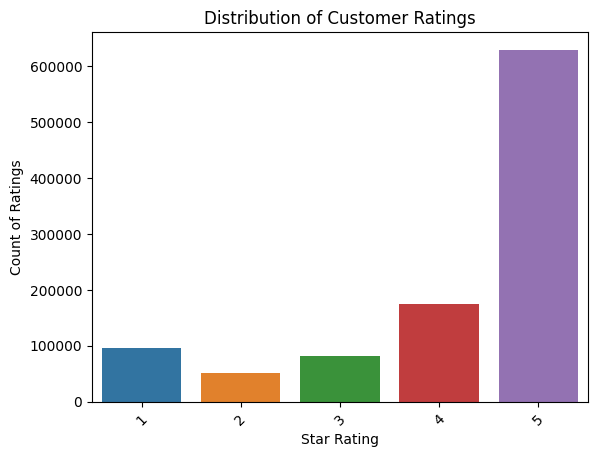

In [16]:
# who v/s fare barplot
sns.barplot(x = 'star_rating',
            y = 'count',
            data = ratingCounts)
plt.xticks(rotation=45) 
plt.xlabel("Star Rating")
plt.ylabel("Count of Ratings")
# Add a title to the plot
plt.title("Distribution of Customer Ratings")

# Show the plot
plt.show()

In [17]:
# Cast the "Year" column to integer to remove any decimal places
df2 = df2.withColumn("year", df2["year"].cast("int"))
# Group ratings by year and calculate the count of ratings
ratings_pd = df2.groupBy('year').agg(count('star_rating').alias('count')).orderBy("Year").toPandas()
ratings_pd

,year,count
0,1995,3
1,1996,58
2,1997,382
3,1998,1788
4,1999,6885
5,2000,14215
6,2001,12131
7,2002,11796
8,2003,11494
9,2004,11201


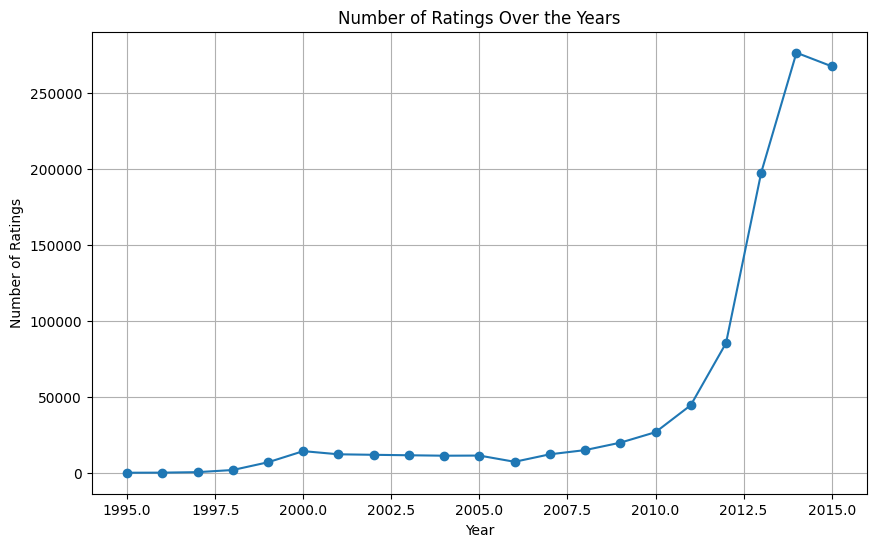

In [18]:
# Plot the line graph using Matplotlib
plt.figure(figsize=(10, 6))
plt.plot(ratings_pd["year"], ratings_pd["count"], marker='o')
plt.xlabel("Year")
plt.ylabel("Number of Ratings")
plt.title("Number of Ratings Over the Years")
plt.grid(True)
plt.show()

In [20]:
# Step 3: Group data and calculate distribution
grouped_df = df2.groupBy('star_rating', 'sentiment').agg(count('*').alias('count'))

# Step 4: Pivot the data for visualization
pivoted_df = grouped_df.groupBy('star_rating').pivot('sentiment').sum('count').fillna(0)

# Step 5: Convert to Pandas DataFrame for visualization
pandas_df = pivoted_df.toPandas()


In [21]:
pandas_df

,star_rating,negative,neutral,positive
0,5,27560,32826,568759
1,1,41932,10467,43738
2,3,14594,4562,62602
3,2,15667,3601,32485
4,4,13821,7724,152841


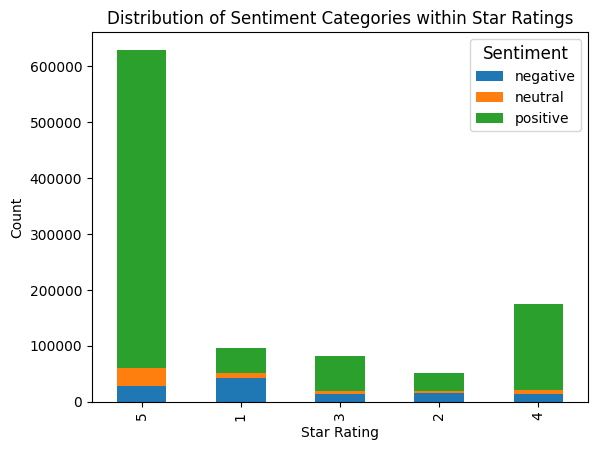

In [22]:
# Step 6: Plot the bar graph
ax = pandas_df.plot(x='star_rating', kind='bar', stacked=True)
ax.set_xlabel("Star Rating")
ax.set_ylabel("Count")
ax.set_title("Distribution of Sentiment Categories within Star Ratings")
plt.legend(title='Sentiment', title_fontsize='large')
plt.show()






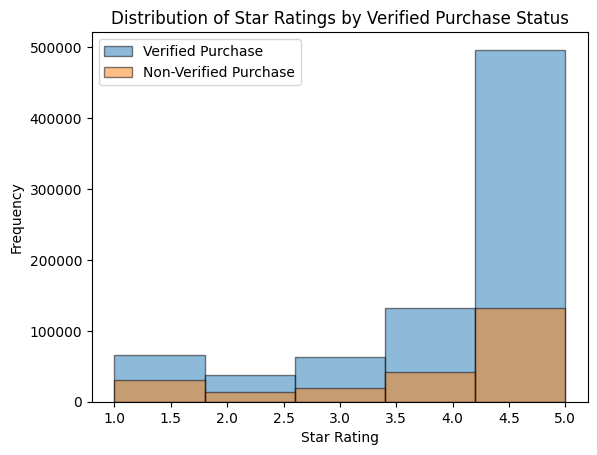

In [23]:
# Separate the star ratings for verified and non-verified purchases
verified_ratings = df2.filter(df2['verified_purchase'] == 'Y').select('star_rating').toPandas()
non_verified_ratings = df2.filter(df2['verified_purchase'] == 'N').select('star_rating').toPandas()

# Plot the distribution of star ratings for verified and non-verified purchases
plt.hist(verified_ratings, bins=5, alpha=0.5, label='Verified Purchase', edgecolor='black')
plt.hist(non_verified_ratings, bins=5, alpha=0.5, label='Non-Verified Purchase', edgecolor='black')

# Set plot labels and title
plt.xlabel('Star Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Star Ratings by Verified Purchase Status')

# Add a legend
plt.legend()

# Display the histogram
plt.show()



##### Review Analysis

In [24]:
# Step 3: Group data and calculate the count for each purchase verification status
grouped_df = df2.groupBy('verified_purchase').agg(count('*').alias('count'))

# Step 4: Convert to Pandas DataFrame for visualization
pandas_df = grouped_df.toPandas()


In [25]:
pandas_df.head()

,verified_purchase,count
0,Y,796120
1,N,237059


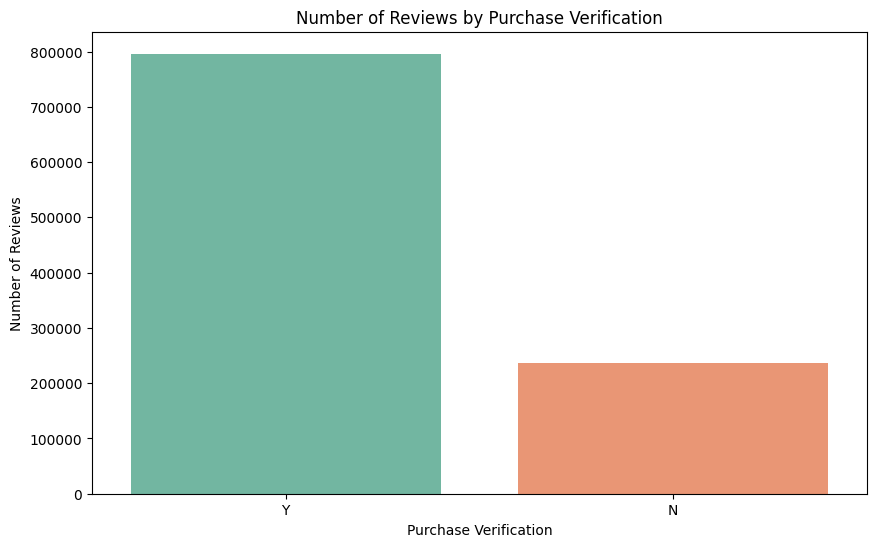

In [26]:
# Create the bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='verified_purchase', y='count', data=pandas_df, palette='Set2')

# Set the x-axis and y-axis labels
plt.xlabel('Purchase Verification')
plt.ylabel('Number of Reviews')

# Set the title of the plot
plt.title('Number of Reviews by Purchase Verification')

# Show the plot
plt.show()

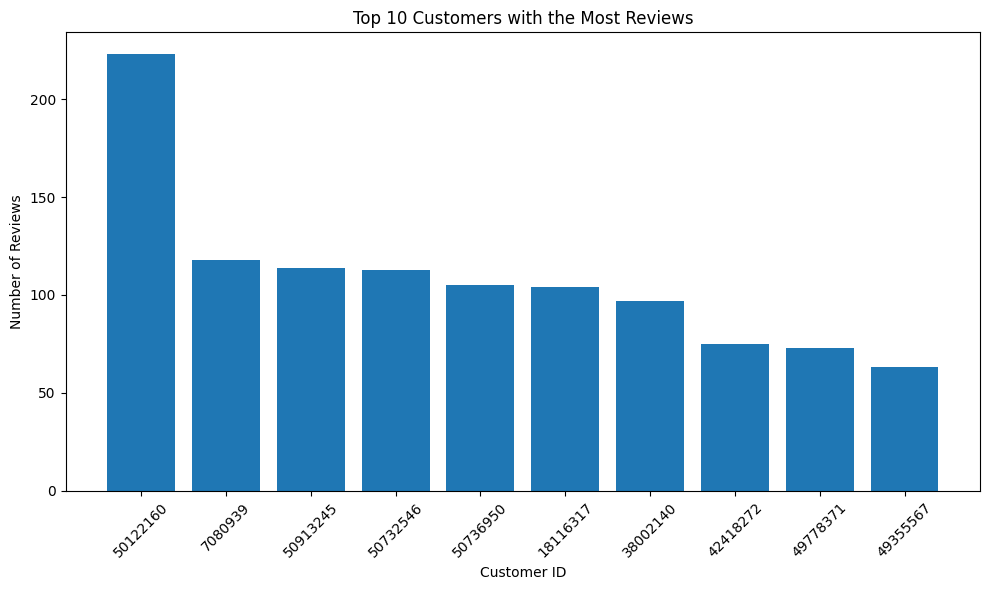

In [27]:
customer_reviews_count = df2.groupBy("customer_id").count()
sorted_customer_reviews = customer_reviews_count.orderBy(col("count").desc())
top_10_customers = sorted_customer_reviews.limit(10).toPandas()

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_10_customers["customer_id"], top_10_customers["count"])
plt.xlabel("Customer ID")
plt.ylabel("Number of Reviews")
plt.title("Top 10 Customers with the Most Reviews")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [28]:
category_reviews_count = df2.groupBy("product_category").count()
sorted_category_reviews = category_reviews_count.orderBy(col("count").desc())
top_10_categories = sorted_category_reviews.limit(10).toPandas()

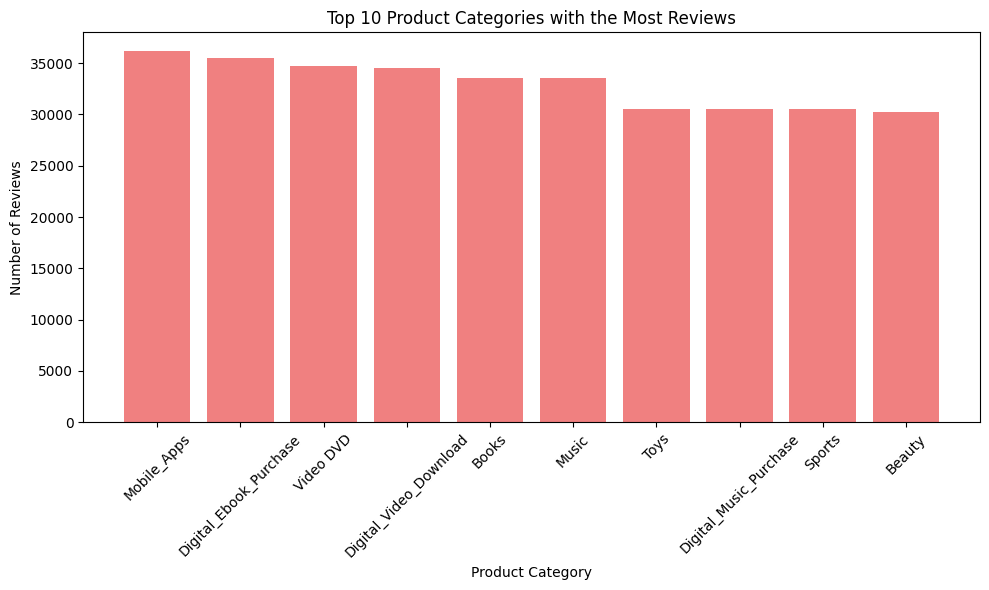

In [29]:
# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_10_categories["product_category"], top_10_categories["count"], color='lightcoral')
plt.xlabel("Product Category")
plt.ylabel("Number of Reviews")
plt.title("Top 10 Product Categories with the Most Reviews")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [30]:

helpful_unhelpful_counts = df2.agg({"helpful_votes": "sum", "unhelpful_votes": "sum"}).collect()[0]


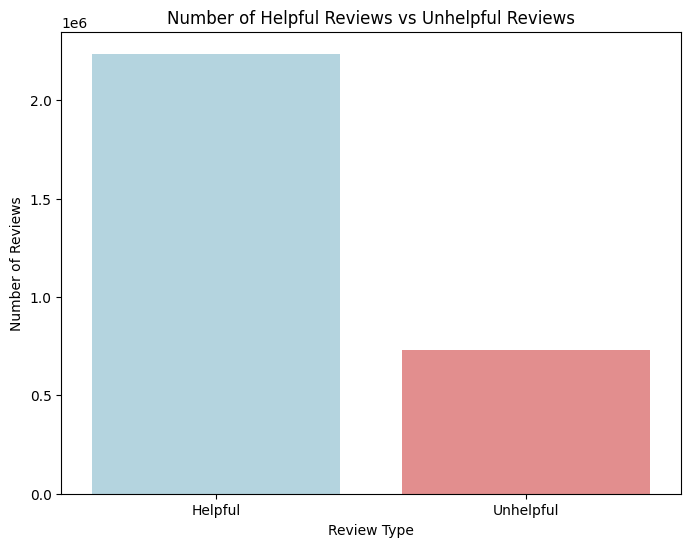

In [31]:

plt.figure(figsize=(8, 6))
sns.barplot(x=['Helpful', 'Unhelpful'], y=[helpful_unhelpful_counts['sum(helpful_votes)'], helpful_unhelpful_counts['sum(unhelpful_votes)']],
            palette=['lightblue', 'lightcoral'])


plt.xlabel('Review Type')
plt.ylabel('Number of Reviews')


plt.title('Number of Helpful Reviews vs Unhelpful Reviews')


plt.show()

In [32]:
def get_month_int(month_name):
    return month_order[month_name]

In [33]:
# Register the UDF
month_to_int_udf = udf(get_month_int, IntegerType())

In [34]:
# Create a dictionary to map month names to their corresponding numerical values
month_order = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}

# Apply the month order mapping to the "month" column
df2 = df2.withColumn('month_int', month_to_int_udf(df2['month']))

# Group by "year" and "month", count the occurrences, and order the results
trends_df = df2.groupBy("year", "month","month_int").agg(f.count("*").alias("count")) \
               .orderBy("year", "month_int").toPandas()

In [35]:
trends_df.head()

,year,month,month_int,count
0,1995,July,7,1
1,1995,August,8,1
2,1995,September,9,1
3,1996,January,1,1
4,1996,May,5,4


In [36]:
def improve_legend(ax=None):
    if ax is None:
        ax = plt.gca()

    lines = ax.lines  # Get all lines in the plot
    legend_handles, legend_labels = ax.get_legend_handles_labels()  # Get legend handles and labels

    for i, line in enumerate(lines):
        data_x, data_y = line.get_data()
        if len(data_x)>0 and len(data_y)>0:
            first_x = data_x[0]
            first_y = data_y[0]
            year = legend_labels[i]  # Get the year from the legend labels
            color = legend_handles[i].get_color()  # Get the color from the legend handles
            ax.annotate(
                year,
                xy=(first_x, first_y),
                xytext=(5, 0),
                textcoords="offset points",
                ha="left",
                va="center",
                color=color,
            )

C:\Users\dn10657\AppData\Local\Temp\ipykernel_34100\1653417986.py:6: UserWarning: 
The palette list has fewer values (10) than needed (21) and will cycle, which may produce an uninterpretable plot.
  ax=sns.lineplot(data=trends_df, x="month", y="count", hue="year", palette=custom_palette)


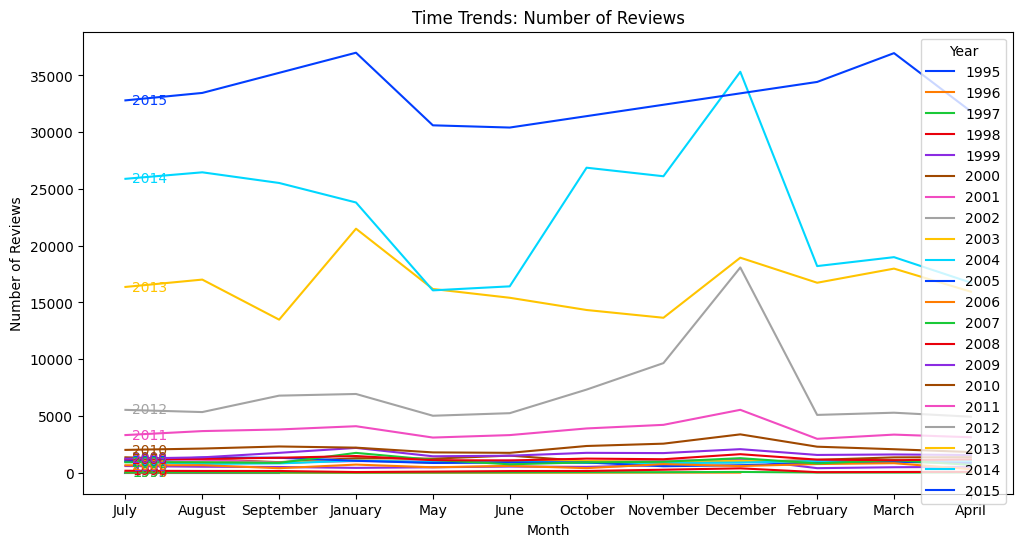

In [37]:
# Define a custom color palette with brighter colors
custom_palette = sns.color_palette("bright")

# Plot the time trends
plt.figure(figsize=(12, 6))
ax=sns.lineplot(data=trends_df, x="month", y="count", hue="year", palette=custom_palette)
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.title("Time Trends: Number of Reviews")

improve_legend(ax)
plt.legend(title="Year")
plt.show()

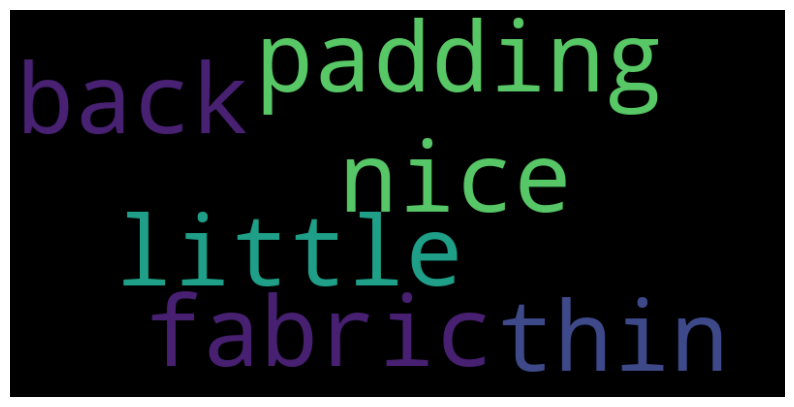

In [38]:
# Join all reviews into a single string
all_reviews = df2.select(concat_ws('', df2['review_body_clean'])).collect()[0][0]

# Create a word cloud object
wordcloud = WordCloud(width=800, height=400, random_state=42, max_font_size=100).generate(all_reviews)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [39]:
def get_text_length(text):
    return len(text)

In [40]:
# Register the UDF
text_length_udf = udf(get_text_length, IntegerType())

In [41]:
# Create the new column "text_length" based on the length of the "review_body" column
#df2 = df2.withColumn('text_length', text_length_udf(df2['review_body_clean']))

In [42]:
df2.limit(1).toPandas()

,abs_sentiment_score,customer_id,helpful_votes,lemmas,month,product_category,product_id,product_title,review_body,review_body_clean,...,sentiment_score,star_rating,stop_removed,token,total_votes,unhelpful_votes,verified_purchase,vine,year,month_int
0,0.048125,32738915,0,"[padding, nice, fabric, back, little, thin]",April,Outdoors,B00ALVDPKU,Pearl Izumi Men's Elite Gel Glove,"padding very nice, fabric on back a little thin",padding very nice fabric on back a little thin,...,0.048125,4,"[padding, nice, fabric, back, little, thin]","[padding, very, nice, fabric, on, back, a, lit...",0,0.0,Y,N,2015,4


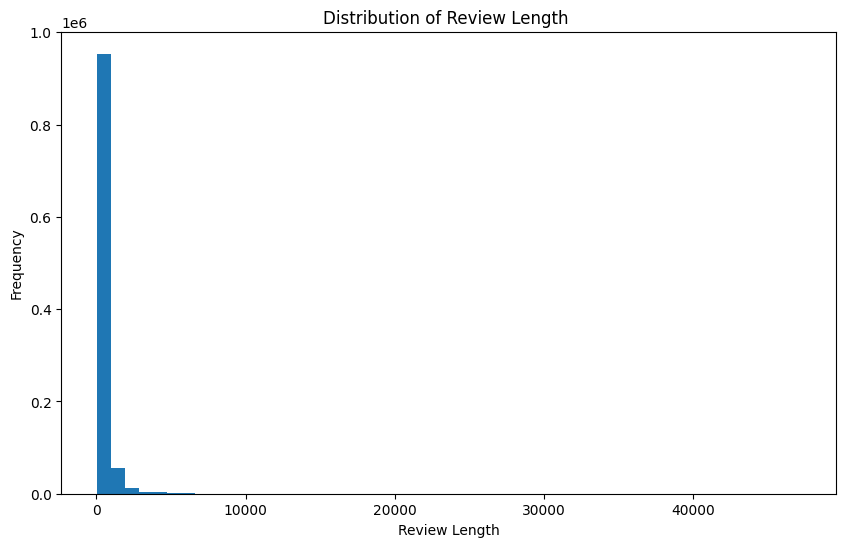

In [43]:
newdf=df2.select("review_text_length").toPandas()


# Distribution plot of text length
plt.figure(figsize=(10, 6))
plt.hist(newdf['review_text_length'], bins=50)
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.title('Distribution of Review Length ')
plt.show()

In [44]:
# Group the data by the 'vine' column and count the number of reviews for each category
review_counts = df2.groupBy('vine').count().orderBy('vine')

In [45]:
review_counts.show()

+----+-------+
|vine|  count|
+----+-------+
|   N|1029579|
|   Y|   3600|
+----+-------+



In [46]:
newdf=review_counts.toPandas()

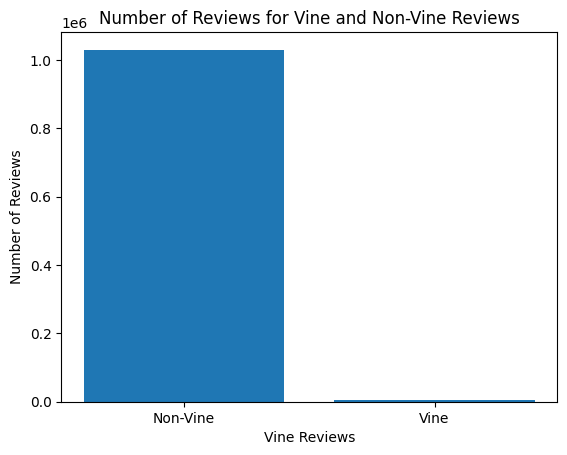

In [47]:
# Create the bar chart using matplotlib
plt.bar(newdf['vine'], newdf['count'])
plt.xlabel('Vine Reviews')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews for Vine and Non-Vine Reviews')
plt.xticks([0, 1], ['Non-Vine', 'Vine'])
plt.show()

In [48]:
# Group the data by "customer_id" and count the number of reviews for each customer
customer_review_counts = df2.groupBy('customer_id').agg(count('review_id').alias('review_count'))

# Calculate the average number of reviews per customer
average_reviews = customer_review_counts.select(avg('review_count')).collect()[0][0]

# Print the average number of reviews per customer
print(f"On average, each customer gives {average_reviews:.2f} reviews.")

On average, each customer gives 1.12 reviews.


#### identify fake or manipulated reviews

In [50]:
reviewsDF=spam_df.select("review_text_length","labels","sentiment_score","sentiment","class").toPandas()

Text(0.5, 1.0, 'Distribution of Review Text Length')

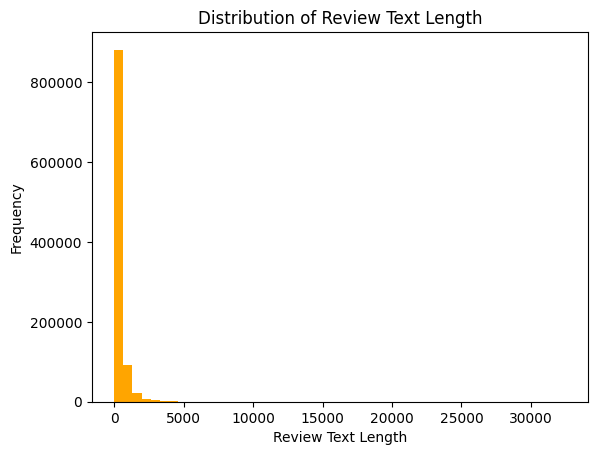

In [51]:
reviewsDF["review_text_length"].plot(bins=50,kind='hist',color='orange')

# Set axis labels and title
plt.xlabel('Review Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Review Text Length')

In [52]:
# Filter the DataFrame for 'ham' and 'spam' labels

ham = reviewsDF[reviewsDF["labels"]=="ham"]
spam = reviewsDF[reviewsDF["labels"]=="spam"]

In [53]:
ham["labels"].value_counts()

labels
ham    224536
Name: count, dtype: int64

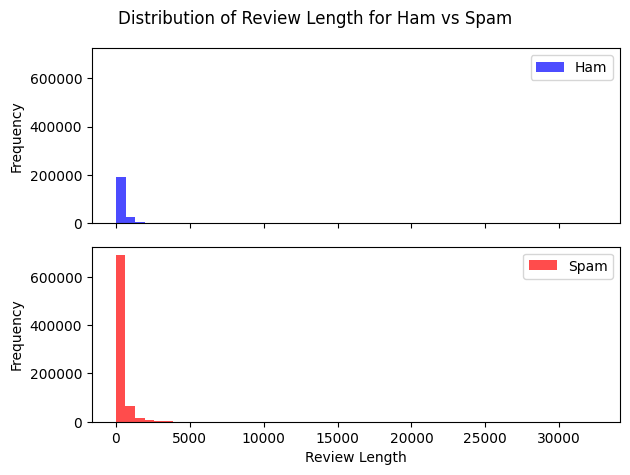

In [54]:
# Generate separate histograms for 'ham' and 'spam' subsets
fig, axes = plt.subplots(2, sharex=True, sharey=True)
ham["review_text_length"].plot(kind="hist", bins=50, ax=axes[0], color="blue", alpha=0.7)
spam["review_text_length"].plot(kind="hist", bins=50, ax=axes[1], color="red", alpha=0.7)

# Set axis labels and title
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.suptitle('Distribution of Review Length for Ham vs Spam')

# Add legend
axes[0].legend(["Ham"])
axes[1].legend(["Spam"])

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [55]:
# Extract the correlations

correlation_matrix = reviewsDF[["class", "review_text_length", "sentiment_score"]].corr()
correlation_length = correlation_matrix.loc["class", "review_text_length"]
correlation_sentiment = correlation_matrix.loc["class", "sentiment_score"]

print("Correlation between review length and labels:", correlation_length)
print("Correlation between sentiment and labels:", correlation_sentiment)

Correlation between review length and labels: -0.04516894799972395
Correlation between sentiment and labels: 0.39437279107268464


In [56]:
reviewDF=spam_df[["labels","reviewDate","review_text_length","sentiment"]].toPandas()

In [57]:
reviewDF.head()

,labels,reviewDate,review_text_length,sentiment
0,spam,2002-01-13,231,positive
1,spam,2009-12-22,1545,positive
2,ham,2011-01-31,234,positive
3,ham,2013-11-04,167,negative
4,spam,2014-01-24,141,positive


In [58]:
reviewDF.dtypes

labels                object
reviewDate            object
review_text_length     int64
sentiment             object
dtype: object

In [59]:
reviewDF["reviewDate"]=pd.to_datetime(reviewDF['reviewDate'])

In [60]:
reviewDF.head()

,labels,reviewDate,review_text_length,sentiment
0,spam,2002-01-13,231,positive
1,spam,2009-12-22,1545,positive
2,ham,2011-01-31,234,positive
3,ham,2013-11-04,167,negative
4,spam,2014-01-24,141,positive


In [61]:
reviewDF.dtypes

labels                        object
reviewDate            datetime64[ns]
review_text_length             int64
sentiment                     object
dtype: object

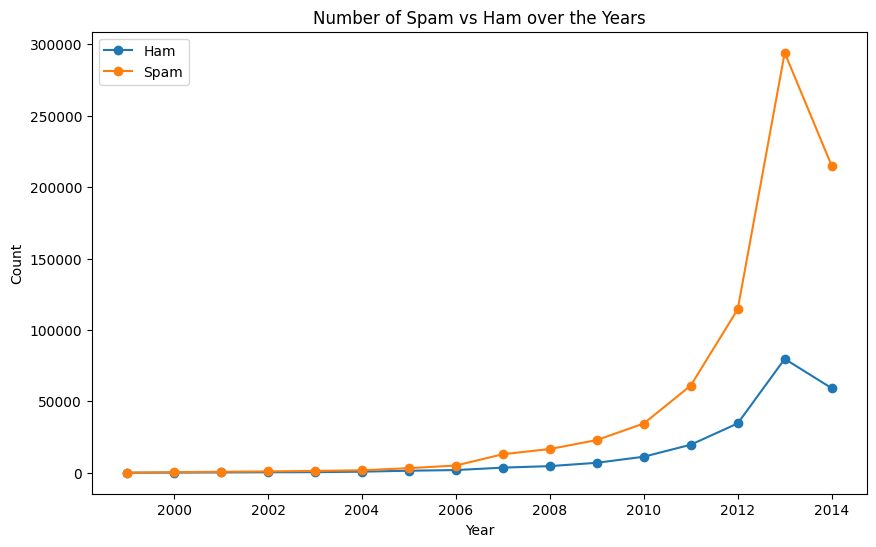

In [62]:
grouped_df = reviewDF.groupby([reviewDF['reviewDate'].dt.year, 'labels']).size().unstack().fillna(0)
# Plot the number of spam vs ham over the years
ax = grouped_df.plot(kind='line', marker='o', linestyle='-', figsize=(10, 6))

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Number of Spam vs Ham over the Years')

# Set legend
ax.legend(['Ham', 'Spam'])

# Show the plot
plt.show()

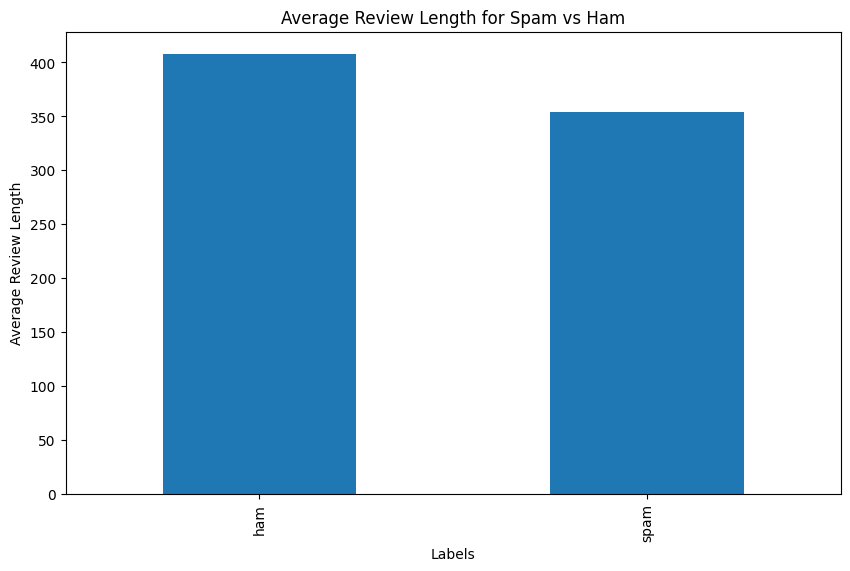

In [63]:
# Group the DataFrame by 'labels' and calculate the mean review length for each category
grouped_df = reviewDF.groupby('labels')['review_text_length'].mean()

# Plot the spam vs ham review length
ax = grouped_df.plot(kind='bar', figsize=(10, 6))

# Set labels and title
plt.xlabel('Labels')
plt.ylabel('Average Review Length')
plt.title('Average Review Length for Spam vs Ham')

# Show the plot
plt.show()

#### Word Cloud

In [109]:
spam_df=spam_df.withColumn("concatenated_lemmas", concat_ws(" ", col("lemmas")))

In [110]:
spam_df.limit(1).toPandas()

,abs_sentiment_score,asin,class,labels,lemmas,reviewDate,reviewText,reviewText_clean,reviewTime,review_text_length,reviewerID,season,sentiment,sentiment_score,stop_removed,token,year,concatenated_lemmas
0,0.642857,B00005OP2S,1.0,spam,"[work, great, great, sound, video, quality, im...",2002-01-13,"Works great for me, great sound and video qual...",works great for me great sound and video quali...,"01 13, 2002",231,A3QPGZ49D7OOEJ,Winter,positive,0.642857,"[works, great, great, sound, video, quality, i...","[works, great, for, me, great, sound, and, vid...",2002,work great great sound video quality im glad g...


In [111]:
spam=spam_df.filter(spam_df.labels == "spam")

In [112]:
ham=spam_df.filter(spam_df.labels == "ham")

In [113]:
spam_reviews=spam.select(spam.concatenated_lemmas).rdd.flatMap(lambda x: x).collect()

In [114]:
len(spam_reviews)

784755

In [115]:
spam_reviews[:2]

['work great great sound video quality im glad great accessory like cord hook tv youre traveling used rebate got free headphone case great value',
 'ive tried kid promise sony best sound quality hand solid build quality compared others seems click place firmly others youve used cassette adapter might know meanforget using fm modulator sound bad outside hard wiring miniplug input stereo sony adapter way goif trouble couple tip low sound volume issue doublecheck volume setting iphoneipod put volume 34 device turn way back little bit dont turn volume way also idea many time ive seen people volume way saying turn car stereo way youre quality issue sound check iphoneipods eq try playing eq turning adding bass booster give horrible result stereo tape click little player prevent little sticking finger slightly moving tape around playing sound like lame fix work like charm also try cleaning tape deck cleaner product helpsall n love sony adapter people recommend cant get one sound good consider

In [116]:
# Convert sentences to a list of words
words_list = [sentence.split() for sentence in spam_reviews]

In [117]:
spam_reviews=[word for sentence in words_list for word in sentence]

In [118]:
spam_reviews[:5]

['work', 'great', 'great', 'sound', 'video']

In [119]:
len(spam_reviews)

26148876

In [120]:
ham_reviews=ham.select(ham.concatenated_lemmas).rdd.flatMap(lambda x: x).collect()

In [121]:
# Convert sentences to a list of words
words_list = [sentence.split() for sentence in ham_reviews]

In [122]:
ham_reviews=[word for sentence in words_list for word in sentence]

In [123]:
# Count the occurrences of each word
spam_word_counts = Counter(spam_reviews)

In [124]:
# Count the occurrences of each word
ham_word_counts = Counter(ham_reviews)

In [125]:
# Select the top 20 words with highest frequencies
spam_top_words = dict(spam_word_counts.most_common(20))

In [126]:
# Select the top 20 words with highest frequencies
ham_top_words = dict(ham_word_counts.most_common(20))

In [127]:
spam_wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(spam_top_words)
ham_wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(ham_top_words)

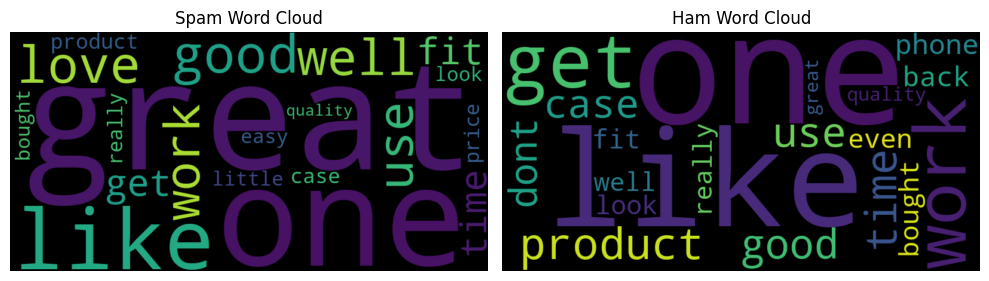

In [128]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(spam_wordcloud, interpolation="bilinear")
plt.title("Spam Word Cloud")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(ham_wordcloud, interpolation="bilinear")
plt.title("Ham Word Cloud")
plt.axis("off")

plt.tight_layout()
plt.show()

#### Bi-grams

In [178]:
ngram = NGram(n=2, inputCol="lemmas", outputCol="ngrams")
bham = ngram.transform(ham)

In [179]:
ngram = NGram(n=2, inputCol="lemmas", outputCol="ngrams")
bspam = ngram.transform(spam)

In [180]:
# Flatten the bigram lists
flat_bigrams_ham = bham.selectExpr("explode(ngrams) as ngrams")

In [181]:
flat_bigrams_ham.show()

+----------------+
|          ngrams|
+----------------+
|  world reviewer|
|  reviewer think|
|     think sound|
|      sound good|
|    good thought|
|   thought brand|
|      brand name|
|       name mean|
|    mean quality|
|quality complete|
|   complete junk|
|      junk sound|
|      sound like|
|    like plastic|
|    plastic junk|
|       junk polk|
|    polk ashamed|
|    ashamed name|
|    name product|
|       brand new|
+----------------+
only showing top 20 rows



In [182]:
# Flatten the bigram lists
flat_bigrams_spam = bspam.selectExpr("explode(ngrams) as ngrams")


In [183]:
flat_bigrams_spam.show()

+---------------+
|         ngrams|
+---------------+
|     work great|
|    great great|
|    great sound|
|    sound video|
|  video quality|
|     quality im|
|        im glad|
|     glad great|
|great accessory|
| accessory like|
|      like cord|
|      cord hook|
|        hook tv|
|       tv youre|
|youre traveling|
| traveling used|
|    used rebate|
|     rebate got|
|       got free|
| free headphone|
+---------------+
only showing top 20 rows



In [184]:
# Count the occurrences of each bigram
bigram_counts_ham = flat_bigrams_ham.groupBy("ngrams").count().orderBy(col("count").desc())


In [185]:
bigram_counts_ham.show()

+----------------+-----+
|          ngrams|count|
+----------------+-----+
|       look like| 5975|
|     waste money| 5561|
|customer service| 4739|
|        year old| 4474|
|       work well| 4100|
|screen protector| 4077|
|       dont know| 4072|
|      first time| 3626|
| stopped working| 3440|
|     even though| 3408|
|         get pay| 3303|
|     doesnt work| 3279|
|       work fine| 2961|
|       feel like| 2857|
|      didnt work| 2838|
|     much better| 2819|
|         new one| 2802|
|        dont buy| 2760|
|   sound quality| 2759|
|         im sure| 2751|
+----------------+-----+
only showing top 20 rows



In [186]:
# Count the occurrences of each bigram
bigram_counts_spam = flat_bigrams_spam.groupBy("ngrams").count().orderBy(col("count").desc())


In [187]:
bigram_counts_spam.show()

+----------------+-----+
|          ngrams|count|
+----------------+-----+
|      work great|29027|
|highly recommend|21908|
|        year old|21830|
|       work well|21730|
|       well made|17046|
|        easy use|16465|
|      look great|15302|
|   great product|14872|
|    good quality|14845|
|     great price|13605|
|   fit perfectly|13339|
|       look like|12875|
|     really like|12641|
|screen protector|12071|
|        fit well| 9971|
|          5 star| 9879|
|     much better| 9873|
|recommend anyone| 9320|
|       make sure| 9219|
|       long time| 8825|
+----------------+-----+
only showing top 20 rows



In [188]:
# Convert the DataFrame to a Pandas DataFrame for easy plotting
bigram_counts_ham_pd = bigram_counts_ham.limit(20).toPandas()

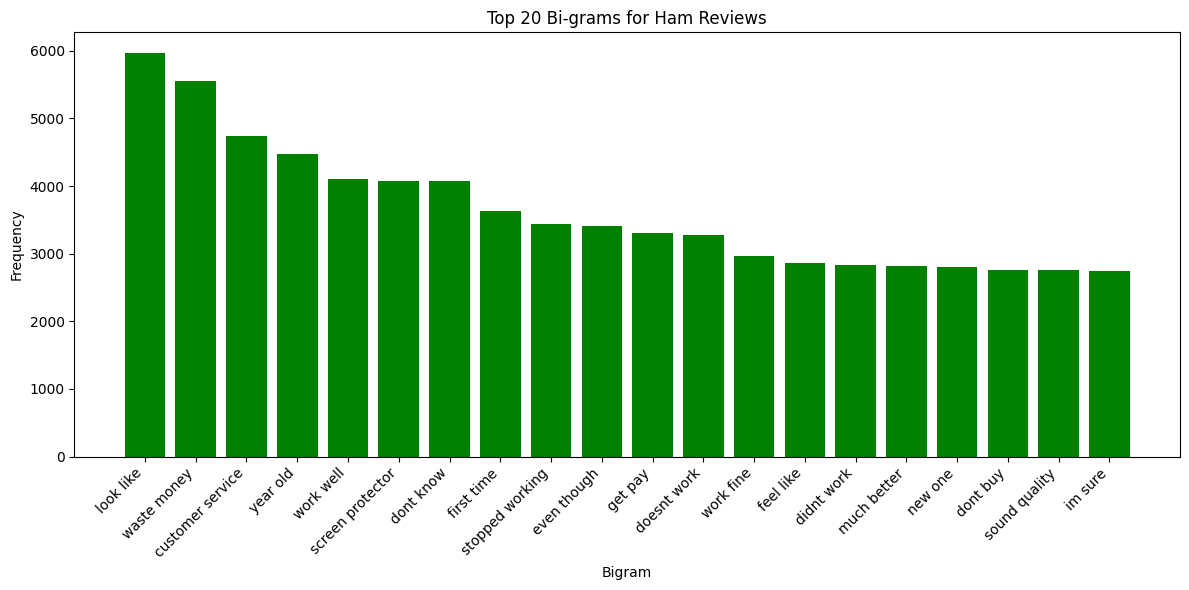

In [189]:
# Plotting the bar chart
plt.figure(figsize=(12, 6))
plt.bar(bigram_counts_ham_pd["ngrams"], bigram_counts_ham_pd["count"],color="green")
plt.xlabel("Bigram")
plt.ylabel("Frequency")
plt.title(f"Top 20 Bi-grams for Ham Reviews")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Display the plot
plt.show()


In [190]:
# Convert the DataFrame to a Pandas DataFrame for easy plotting
bigram_counts_spam_pd = bigram_counts_spam.limit(20).toPandas()

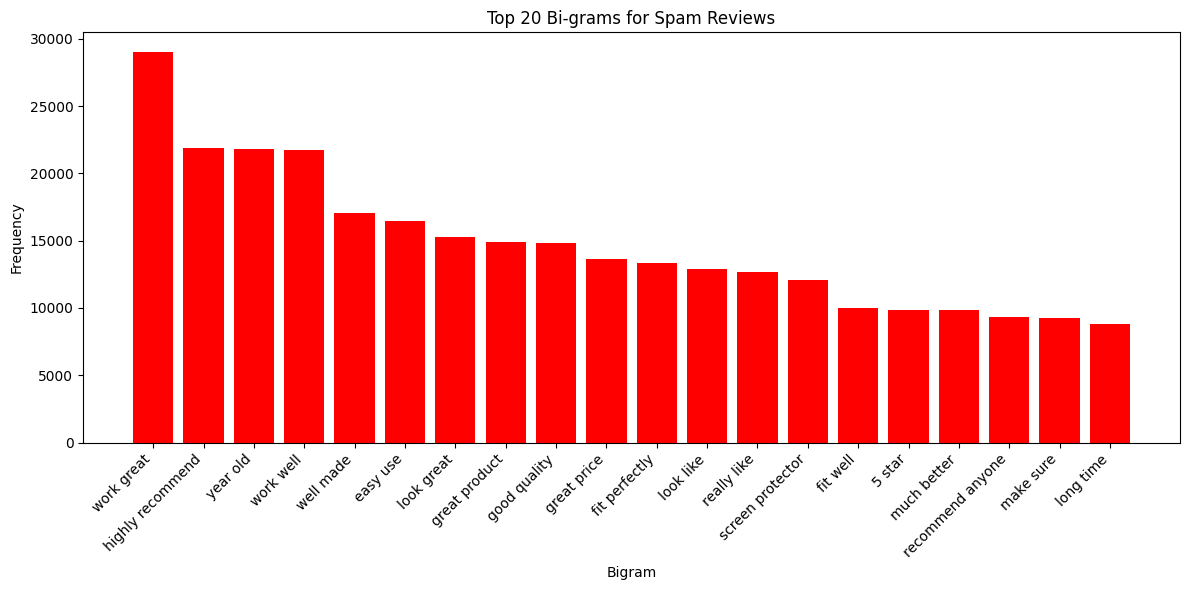

In [191]:
# Plotting the bar chart
plt.figure(figsize=(12, 6))
plt.bar(bigram_counts_spam_pd["ngrams"], bigram_counts_spam_pd["count"],color="red")
plt.xlabel("Bigram")
plt.ylabel("Frequency")
plt.title(f"Top 20 Bi-grams for Spam Reviews")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Display the plot
plt.show()


##### Trigrams

In [192]:
ngram = NGram(n=3, inputCol="lemmas", outputCol="ngrams")
bham = ngram.transform(ham)

In [193]:
ngram = NGram(n=3, inputCol="lemmas", outputCol="ngrams")
bspam = ngram.transform(spam)

In [194]:
# Flatten the bigram lists
flat_trigrams_ham = bham.selectExpr("explode(ngrams) as ngrams")

In [195]:
flat_trigrams_ham.show()

+--------------------+
|              ngrams|
+--------------------+
|world reviewer think|
|reviewer think sound|
|    think sound good|
|  sound good thought|
|  good thought brand|
|  thought brand name|
|     brand name mean|
|   name mean quality|
|mean quality comp...|
|quality complete ...|
| complete junk sound|
|     junk sound like|
|  sound like plastic|
|   like plastic junk|
|   plastic junk polk|
|   junk polk ashamed|
|   polk ashamed name|
|ashamed name product|
|      brand new tone|
| new tone generation|
+--------------------+
only showing top 20 rows



In [196]:
# Flatten the bigram lists
flat_trigrams_spam = bspam.selectExpr("explode(ngrams) as ngrams")


In [197]:
flat_trigrams_spam.show()

+--------------------+
|              ngrams|
+--------------------+
|    work great great|
|   great great sound|
|   great sound video|
| sound video quality|
|    video quality im|
|     quality im glad|
|       im glad great|
|glad great accessory|
|great accessory like|
| accessory like cord|
|      like cord hook|
|        cord hook tv|
|       hook tv youre|
|  tv youre traveling|
|youre traveling used|
|traveling used re...|
|     used rebate got|
|     rebate got free|
|  got free headphone|
| free headphone case|
+--------------------+
only showing top 20 rows



In [198]:
# Count the occurrences of each bigram
trigram_counts_ham = flat_trigrams_ham.groupBy("ngrams").count().orderBy(col("count").desc())


In [199]:
trigram_counts_ham.show()

+--------------------+-----+
|              ngrams|count|
+--------------------+-----+
|    dont waste money| 1554|
|    waste time money|  608|
|       guess get pay|  583|
|     buy another one|  502|
|     first time used|  501|
|     dont waste time|  471|
|      get money back|  417|
|          5 year old|  410|
|        year old son|  409|
|   look like picture|  400|
|          3 year old|  400|
|        get job done|  387|
|   year old daughter|  385|
|          4 year old|  372|
|          2 year old|  351|
|    doesnt work well|  331|
|         gave 3 star|  325|
|   total waste money|  322|
|complete waste money|  306|
|   look nothing like|  291|
+--------------------+-----+
only showing top 20 rows



In [200]:
# Count the occurrences of each bigram
trigram_counts_spam = flat_trigrams_spam.groupBy("ngrams").count().orderBy(col("count").desc())


In [201]:
trigram_counts_spam.show()

+--------------------+-----+
|              ngrams|count|
+--------------------+-----+
|       cant go wrong| 2655|
|      last long time| 2650|
|highly recommend ...| 2392|
|        year old son| 2231|
|         give 5 star| 2207|
|          3 year old| 2200|
|    well worth money| 2176|
|   worth every penny| 2161|
|   year old daughter| 1994|
|   easy put together| 1865|
|          4 year old| 1855|
|          2 year old| 1823|
|      love love love| 1783|
|     cant beat price| 1778|
|recommend anyone ...| 1767|
|          5 year old| 1750|
|        get job done| 1695|
|     buy another one| 1671|
|         gave 4 star| 1514|
|       year old love| 1477|
+--------------------+-----+
only showing top 20 rows



In [202]:
# Convert the DataFrame to a Pandas DataFrame for easy plotting
trigram_counts_ham_pd = trigram_counts_ham.limit(20).toPandas()

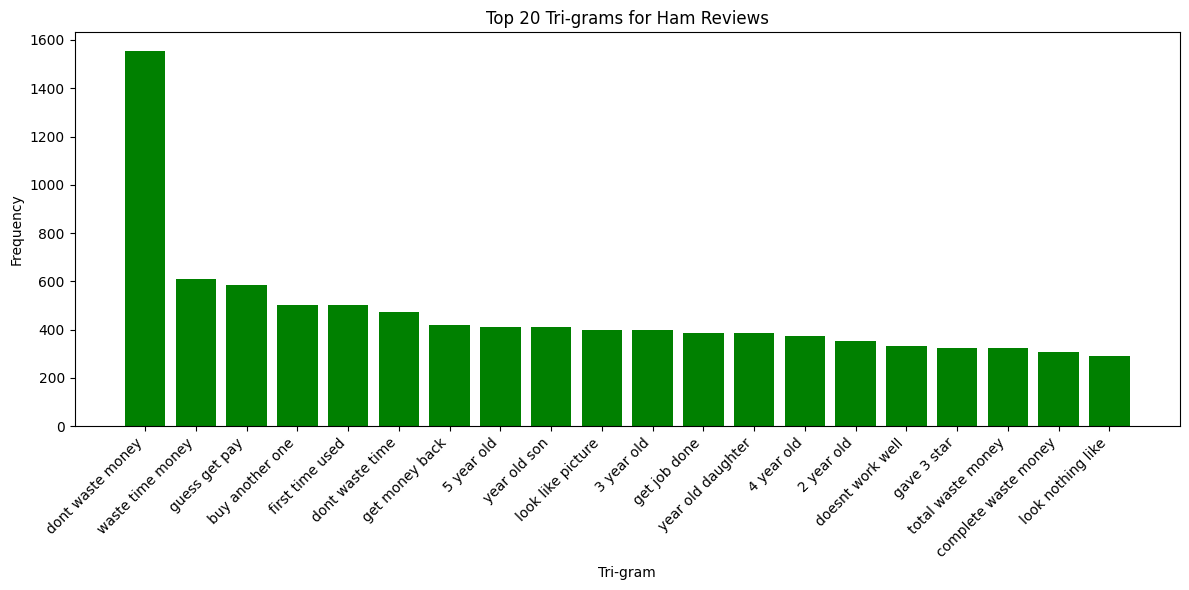

In [203]:
# Plotting the bar chart
plt.figure(figsize=(12, 6))
plt.bar(trigram_counts_ham_pd["ngrams"], trigram_counts_ham_pd["count"],color="green")
plt.xlabel("Tri-gram")
plt.ylabel("Frequency")
plt.title(f"Top 20 Tri-grams for Ham Reviews")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Display the plot
plt.show()


In [204]:
# Convert the DataFrame to a Pandas DataFrame for easy plotting
trigram_counts_spam_pd = trigram_counts_spam.limit(20).toPandas()

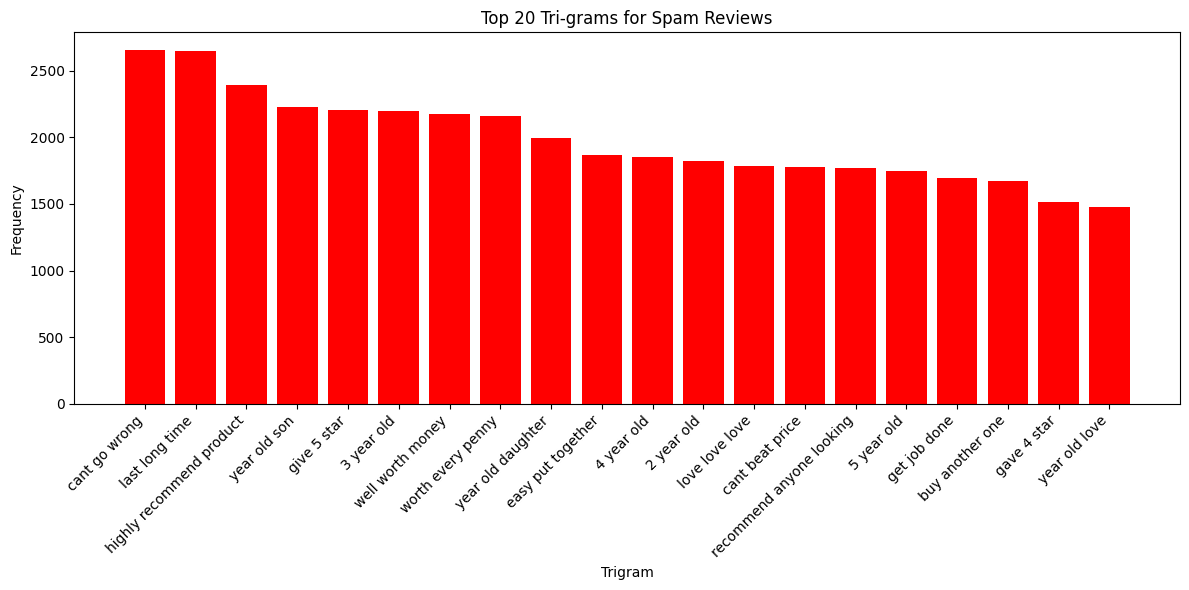

In [205]:
# Plotting the bar chart
plt.figure(figsize=(12, 6))
plt.bar(trigram_counts_spam_pd["ngrams"], trigram_counts_spam_pd["count"],color="red")
plt.xlabel("Trigram")
plt.ylabel("Frequency")
plt.title(f"Top 20 Tri-grams for Spam Reviews")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Display the plot
plt.show()


#### Feature Engineering

##### Amazon Spam Reviews Dataset

In [ ]:
hashingTF = HashingTF(inputCol='lemmas',outputCol='rawFeatures', numFeatures=1000)
idf = IDF(inputCol="rawFeatures", outputCol="tf_idf")
#spam_df = spam_df.withColumn('abs_sentiment_score', abs(spam_df['sentiment_score']))
vectorassembler = VectorAssembler(inputCols=['tf_idf','review_text_length','abs_sentiment_score'],outputCol='raw_features')
scaler = StandardScaler (inputCol="raw_features", outputCol="features")
#pca = PCA(k=2, inputCol="scaled_features", outputCol="features")

In [ ]:
data_prep_pipe = Pipeline(stages=[hashingTF,idf,vectorassembler,scaler])
cleaner = data_prep_pipe.fit(spam_df)
clean_data = cleaner.transform(spam_df)

In [ ]:
cleaner.write().overwrite().save(r"C:\Users\dn10657\source\repos\Capstone\pipelines\data_prep_pipe")

In [ ]:
clean_data.limit(5).toPandas()

In [69]:
clean_data = clean_data.select(["reviewText",'class','features'])

In [70]:
clean_data = clean_data.withColumnRenamed("class", "label")

In [71]:
# Split the data into training and testing sets
train_data, test_data = clean_data.randomSplit([0.8, 0.2], seed=0)

#### Model Building

##### Amazon Spam Reviews Dataset

#### Naive Bayes Model

In [21]:
# Define the Naive Bayes classifier
nb = NaiveBayes()

# Define the hyperparameter grid for tuning
nbparam_grid = ParamGridBuilder() \
    .addGrid(nb.smoothing, [0.1, 1.0, 10.0]) \
    .build()

# Set up the TrainValidationSplit with the NaiveBayes classifier and parameter grid
nbtvs = TrainValidationSplit(estimator=nb,
                           estimatorParamMaps=nbparam_grid,
                           evaluator=BinaryClassificationEvaluator(),
                           trainRatio=0.8)

In [22]:
# Fit the TrainValidationSplit on the training data
nbtvs_model = nbtvs.fit(train_data)

In [23]:
# Get the best NaiveBayes model from the TVS model
nbmodel = nbtvs_model.bestModel

In [24]:
# Extract the best hyperparameters
best_smoothing = nbmodel._java_obj.getSmoothing()

In [25]:
# Print the best hyperparameters
print(f"Best Smoothing Parameter: {best_smoothing}")

Best Smoothing Parameter: 10.0


In [26]:

# Make predictions on the test data
predictions = nbmodel.transform(test_data)

In [27]:
# Evaluate the model's accuracy on the validation data
nbevaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
nbareaUnderROC = nbevaluator.evaluate(predictions)

In [28]:
nbareaUnderROC

0.5632969227855361

In [29]:
nbevaluator = BinaryClassificationEvaluator(metricName="areaUnderPR")
nbareaUnderPR = nbevaluator.evaluate(predictions)

In [30]:
nbareaUnderPR

0.8096010485560644

In [ ]:
nbmodel.write().overwrite().save(r"C:\Users\dn10657\source\repos\Capstone\models\nbModel")

#### Support Vector Machine Model

In [ ]:
# Define the LinearSVC classifier
svm = LinearSVC()

# Define the hyperparameter grid for tuning
svmparam_grid = ParamGridBuilder() \
    .addGrid(svm.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(svm.maxIter, [10, 100]) \
    .build()


# Set up the TrainValidationSplit with the SVM classifier and parameter grid
svmtvs = TrainValidationSplit(estimator=svm,
                           estimatorParamMaps=svmparam_grid,
                           evaluator=BinaryClassificationEvaluator(),
                           trainRatio=0.8)

In [ ]:
svmtvs_model = svmtvs.fit(train_data)

In [ ]:
svmmodel=svmtvs_model.bestModel

In [33]:
# Retrieve the best parameters
svmbest_reg_param = svmmodel._java_obj.getRegParam()
svmbest_max_iter = svmmodel._java_obj.getMaxIter()

In [34]:
print(f"Best Model Parameters: RegParam={svmbest_reg_param}, MaxIter={svmbest_max_iter}")

Best Model Parameters: RegParam=0.01, MaxIter=10


In [72]:
# Make predictions on the validation data
predictions = svmmodel.transform(test_data)

In [77]:
pd.set_option("display.max_colwidth", None)

In [82]:
predictions.select("reviewText", "prediction").limit(5).toPandas()

,reviewText,prediction
0,&#128525;&#128525;&#128525;&#128525;&#128525; love love love haven't gotten a chance to wear them yet but can't wait!!!! A little small but I manage to make them fit by sliding my feet to the front !! They are so adorable on my feet . I ordered a 8.5 I wear an 8 in closed toe and 8.5 in open toe but theses ones were a little small !! Love them though !!&#10084;&#65039;&#10084;&#65039;&#10084;&#65039;,1.0
1,"&#1589;&#1575;&#1606;&#1593; &#1575;&#1604;&#1585;&#1608;&#1594;&#1577; , &#1578;&#1580;&#1585;&#1576;&#1577; &#1588;&#1585;&#1575;&#1569; &#1580;&#1610;&#1583;&#1577; , &#1575;&#1604;&#1602;&#1591;&#1593;&#1577; &#1580;&#1605;&#1610;&#1604;&#1607; &#1606;&#1608;&#1593;&#1575; &#1605;&#1575; &#1608;&#1578;&#1589;&#1606;&#1594; &#1604;&#1603; &#1585;&#1594;&#1608;&#1577; &#1585;&#1575;&#1574;&#1593;&#1577; &#1605;&#1606; &#1575;&#1604;&#1589;&#1575;&#1576;&#1608;&#1606; &#1575;&#1604;&#1587;&#1575;&#1574;&#1604; , &#1578;&#1580;&#1585;&#1576;&#1577; &#1604;&#1575;&#1576;&#1575;&#1574;&#1587; &#1576;&#1607;&#1575;",1.0
2,"(...)Here are the details:Access your music without taking your player out of the bag! The convenient pocket clip secures your MP3 player to your belt, purse or backpack. The FM Wired Remote combines FM tuner capabilities, a built-in microphone, a cool blue backlit LCD, as well as the playback controls. Listen to or even record your favorite FM stations!Features Include:Blue Luminescent Backlit LCDBuilt-in Microphone for Voice RecordingRadio Recording in Stereo32 FM Preset ChannelsRadio Frequency AutoscanText Display for Track informationBattery and EAX IndicatorElapsed Time CounterClockI hope this helps.",1.0
3,(...)Since I have installed various Wi-Fi Routers and Access Points for a number clients the Router was fairly easy to configure and set up WPA security. This Router is cerainly not the easiest product to set up.The router drops wireless connections and the only way to reconnect is to reboot the router. This is true for Netgear PC Card with Super G as well as other Wi-Fi vendors.,1.0
4,"(Note: review copied from other horse in collection) My 4 year old daughter loves horses, so if it's shaped like a horse I can't go wrong! (Basically she is going to like it regardless if it's worth the money I paid!) I liked the additional fact that the horse's head and leg moves and the realistic sounds. Doll sits okay on the horse...it's made so that the legs are moveable in most directions and jointed (unlike the Barbie that comes with a horse and legs aren't too easy to bend apart to it get to stay on)I also have the other two colors for her in the collection...using this review for both purchased on Amazon. Pretty sturdy, made it through several drops so far and of course she loves them. Lily gray and her rider are smaller than Aspen Gold or Sugar. Saddle and blanket are sewn together but removeable from horse. A little pricy because they are hard to find.",1.0


In [80]:
predictions.select("reviewText", "prediction").filter(col("prediction")==0.0).limit(5).toPandas()

,reviewText,prediction
0,"+ POINTS:== Good product overall.== Very very easy to assemble.== It was delivered in like a week.== Comfortable to sit.- POINTS:== Front legs are just too weak.== It makes noise.== Uncomfortable to sleep.03/2013== UPDATE ==Both legs broke within 6 months, I am just 76Kg.. which should be around 140lb.I had to put some wood blocks below it.. Beside the weak legs it's a good product for the price.",0.0
1,"... it happens.Mine would link up with the three different items I paired it to, but I couldn't get any audio from it. even tried another type of dock. I also set my iPod into the main dock on the Onkyo HT's RI Dock to be sure my settings were still set right and audio came blasting through that way. But not from this unit. Guess I got a bad one.Decided to go a different route with a better name brand. Hope that one isn't broke. I have that kind of luck sometimes.",0.0
2,"..as I'd buy this in every color.Strange thing, though, regarding the style number. I ordered 3 Glamorise bras in one order just recently. 2 of them fit and 1 did not. In my order history and on my invoice, the description for this bra is ""Magic Lift Front Close Posture Support Bra"". The style number on the tag is 1275.I also ordered Style 1265, which is NOT this one. Yet the description matches this one-""Soft Shoulders Comfort Back Support Bra"". That one, which says style 1265, is too big in the band and the cup size.",0.0
3,.Battery life is rediculous wicked bad. Laughable really. Othef than that its a good pphone. Cant belive how bad it is,0.0
4,"1. I love the mats. They are incredible and feel great when working in the kitchen. I highly recommend them. I'd give the product five stars.2. I ordered Cinnamon mats. The boxes said they were Cinnamon, but they were dark brown, not the orangish brown ones I ordered. It's pretty clear that to have two mislabeled boxes means someone substituted the dark brown mats on purpose.I wasn't amused. Although I didn't return them or complain to the Amazon, I wouldn't buy this from Amazon again.Either the vendor supplying them to Amazon substituted the wrong color in the Cinnamon boxes or someone at the Amazon warehouse took it upon themselves to make the substitution prior to shipping. I don't know which, but either way, I was not satisfied with my order because of it.I'm only giving three stars because of the color change.",0.0


In [36]:
# Evaluate the model's accuracy on the validation data
svmevaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
svmareaUnderROC = svmevaluator.evaluate(predictions)

In [37]:
svmareaUnderROC

0.8605244610292484

In [38]:
# Evaluate the model's accuracy on the validation data
svmevaluator = BinaryClassificationEvaluator(metricName="areaUnderPR")
svmareaUnderPR = svmevaluator.evaluate(predictions)

In [39]:
svmareaUnderPR

0.9455896999613053

In [ ]:
svmmodel.write().overwrite().save("C:\Users\dn10657\source\repos\Capstone\models\svmmodel")

#### Decision Tree Classifier Model

In [ ]:
# Create an instance of DecisionTreeClassifier
dt = DecisionTreeClassifier(maxDepth=15)

# Define the hyperparameter grid for tuning
dtparam_grid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [3, 5, 7]) \
    .addGrid(dt.maxBins, [16, 32, 64]) \
    .addGrid(dt.minInstancesPerNode, [1, 5, 10]) \
    .addGrid(dt.minInfoGain, [0.0, 0.1, 0.2]) \
    .build()

# Set up the TrainValidationSplit with the DecisionTreeClassifier and parameter grid
dttvs = TrainValidationSplit(estimator=dt,
                           estimatorParamMaps=dtparam_grid,
                           evaluator=BinaryClassificationEvaluator(),
                           trainRatio=0.8)



In [ ]:
dttvs_model = dttvs.fit(train_data)

In [ ]:
dtmodel=dttvs_model.bestModel

In [41]:
# Extract the parameter map from the best model
best_params = dtmodel.extractParamMap()

In [42]:
# Print the hyperparameters and their values
for param in best_params:
    print(f"{param.name}: {best_params[param]}")

cacheNodeIds: False
checkpointInterval: 10
featuresCol: features
impurity: gini
labelCol: label
leafCol: 
maxBins: 16
maxDepth: 5
maxMemoryInMB: 256
minInfoGain: 0.0
minInstancesPerNode: 5
minWeightFractionPerNode: 0.0
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
seed: -1769114147992414521


In [43]:
# Make predictions on the validation data
predictions = dtmodel.transform(test_data)

In [44]:
# Evaluate the model's accuracy on the validation data
dtevaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
dtareaUnderROC = dtevaluator.evaluate(predictions)

In [45]:
dtareaUnderROC

0.7000755362423733

In [46]:
# Evaluate the model's accuracy on the validation data
dtevaluator = BinaryClassificationEvaluator(metricName="areaUnderPR")
dtareaUnderPR = dtevaluator.evaluate(predictions)

In [47]:
dtareaUnderPR

0.88136986898895

In [ ]:
dtmodel.write().overwrite().save(r"C:\Users\dn10657\source\repos\Capstone\models\dtmodel")

#### K-means Clustering Content-Based Recommendation Engine

In [48]:
df2.show()

+--------------------+-----------+-------------+--------------------+--------+----------------+----------+--------------------+--------------------+--------------------+-----------+--------------------+--------------+------------------+------+---------+--------------------+-----------+--------------------+--------------------+-----------+---------------+-----------------+----+----+
| abs_sentiment_score|customer_id|helpful_votes|              lemmas|   month|product_category|product_id|       product_title|         review_body|   review_body_clean|review_date|     review_headline|     review_id|review_text_length|season|sentiment|     sentiment_score|star_rating|        stop_removed|               token|total_votes|unhelpful_votes|verified_purchase|vine|year|
+--------------------+-----------+-------------+--------------------+--------+----------------+----------+--------------------+--------------------+--------------------+-----------+--------------------+--------------+-------------

In [49]:
grouped_df = df2.groupBy("product_id","product_title").agg(
    avg("abs_sentiment_score").alias("avg_abs_sentiment"),
    avg("review_text_length").alias("avg_review_length"),
    round(avg("star_rating"),0).alias("avg_star_rating"),
    collect_list("lemmas").alias("combined_tokens")
)
grouped_df = grouped_df.withColumn("combined_tokens", flatten(col("combined_tokens")))

In [50]:
grouped_df.show()

+----------+--------------------+-------------------+------------------+---------------+--------------------+
|product_id|       product_title|  avg_abs_sentiment| avg_review_length|avg_star_rating|     combined_tokens|
+----------+--------------------+-------------------+------------------+---------------+--------------------+
|0002253372|        A Good Woman|0.34062499999999996|            1237.0|            5.0|[found, book, mys...|
|0002570246|        Trusted Mole|0.06933396464646464|            2637.0|            2.0|[general, mike, r...|
|000470763X|Collins Gem Latin...|0.10035714285714287|            1602.0|            5.0|[collins, gem, la...|
|0004722221|Collins Gem Greek...| 0.1111111111111111|             906.0|            1.0|[id, like, review...|
|0006392873|      Alice, I Think|0.15494505494505495|             845.0|            5.0|[couldnt, help, r...|
|0006470173|         The Pyrates|0.13020833333333337|            1230.0|            4.0|[here, totally, a...|
|000711786

In [ ]:
grouped_df.count()

In [ ]:
hashingTF = HashingTF(inputCol="combined_tokens", outputCol="rawFeatures", numFeatures=1000)
idf = IDF(inputCol="rawFeatures", outputCol="result")

In [ ]:
# Select the relevant features for clustering
feature_columns = ["avg_review_length", "avg_abs_sentiment", "result"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="raw_features")
#reviews_data = assembler.transform(reviews_data)

In [ ]:
# Normalize the features column
normalizer = Normalizer(inputCol="raw_features", outputCol="normalized_features")

In [ ]:
pca = PCA(k=2, inputCol="normalized_features", outputCol="features")

In [ ]:
# Pipeline for feature engineering
pipeline = Pipeline(stages=[hashingTF, idf,assembler,normalizer,pca])
pipeline_model = pipeline.fit(grouped_df)
df_transformed = pipeline_model.transform(grouped_df)

In [83]:
# Split the data into training and testing sets
train_data, test_data = df_transformed.randomSplit([0.8, 0.2], seed=0)

In [56]:
# Create an instance of KMeans
kmeans = KMeans()


# Create a ParamGridBuilder to define the hyperparameter grid
kmparam_grid = ParamGridBuilder() \
    .addGrid(kmeans.k, [2, 3, 4]) \
    .addGrid(kmeans.maxIter, [10, 20, 30]) \
    .build()

# Define the evaluator
kmevaluator = ClusteringEvaluator()

# Create a TrainValidationSplit instance
kmtvs = TrainValidationSplit(estimator=kmeans,
                           estimatorParamMaps=kmparam_grid,
                           evaluator=kmevaluator,
                           trainRatio=0.8)

In [ ]:
kmtvsModel = kmtvs.fit(train_data)

In [ ]:
cbKmeansmodel=kmtvsModel.bestModel

In [ ]:
clustered_data = cbKmeansmodel.transform(test_data)

In [58]:
# Evaluate the clustering performance using Silhouette Score
silhouette_score = kmevaluator.evaluate(clustered_data, {kmevaluator.metricName: "silhouette"})
print("Silhouette Score:", silhouette_score)

Silhouette Score: 0.9932423282885875


In [ ]:
cbKmeansmodel.write().overwrite().save(r"C:\Users\dn10657\Documents\CAP\nicholsonderon1995\models\kmeansmodel")

In [ ]:
pipeline_model.write().overwrite().save(r"C:\Users\dn10657\Documents\CAP\nicholsonderon1995\pipelines\clustering_pipeline1")

#### Hierarchial Clustering Model

In [62]:
# Initialize BisectingKMeans estimator
bkm = BisectingKMeans()

# Define parameter grid for hyperparameter tuning
bkmparam_grid = ParamGridBuilder() \
    .addGrid(bkm.k, [2, 3, 4, 5]) \
    .addGrid(bkm.maxIter, [10, 20, 30]) \
    .build()

# Initialize evaluator
bkmevaluator = ClusteringEvaluator()

# Initialize TrainValidationSplit
bkmtvs = TrainValidationSplit(estimator=bkm,
                           estimatorParamMaps=bkmparam_grid,
                           evaluator=bkmevaluator,
                           trainRatio=0.8)

In [ ]:
# Fit the TrainValidationSplit to training data
bkmtvs_model = bkmtvs.fit(train_data)

In [ ]:
bkmmodel=bkmtvs_model.bestModel

In [ ]:
bkmclustered_data = bkmmodel.transform(test_data)

In [63]:
# Evaluate the clustering performance using Silhouette Score
silhouette_score = bkmevaluator.evaluate(bkmclustered_data, {bkmevaluator.metricName: "silhouette"})
print("Silhouette Score:", silhouette_score)

Silhouette Score: 0.9923917202730984


In [ ]:
bkmmodel.write().overwrite().save(r"C:\Users\dn10657\Documents\CAP\nicholsonderon1995\models\hclustermodel")

In [85]:
#Find similar products within the same cluster for a target product from the test data
target_product_id = test_data.first()["product_id"]


In [86]:
target_product_id

'002864283X'

In [88]:
target_product_cluster = clustered_data.filter(col("product_id")==target_product_id).first()["prediction"]

In [89]:
target_product_cluster

0

In [93]:
product_cluster_data=clustered_data\
.select("prediction","product_id","features","product_title","avg_star_rating")\
.filter(col("prediction")==target_product_cluster)

In [ ]:
product_cluster_data.limit(2).toPandas()

In [90]:
product_data=clustered_data.select("prediction","product_id","features","product_title","avg_star_rating")\
.filter((col("prediction")==target_product_cluster) & (col("product_id")==target_product_id)).limit(1)

In [91]:
product_data.limit(2).toPandas()

,prediction,product_id,features,product_title,avg_star_rating
0,0,002864283X,"[-0.775547193030904, -0.11551594468361157]",Become A Recognized Authority In Your Field - In 60 Days Or Less,5.0


In [94]:
# Define a UDF to calculate cosine similarity
def cosine_similarity(vector1, vector2):
    dot_product = float(vector1.dot(vector2))
    magnitude_product = float(vector1.norm(2) * vector2.norm(2))
    return dot_product / magnitude_product

cosine_similarity_udf = udf(cosine_similarity)

# Cross-join normalized features with itself to get all pairwise combinations
cross_joined_data = product_data.alias("a").crossJoin(product_cluster_data.alias("b"))


In [95]:
# Calculate cosine similarity and select relevant columns
cosine_similarity_df = cross_joined_data.select(
    "a.product_id",
    "b.product_id",
    cosine_similarity_udf("a.features", "b.features").alias("cosine_similarity")
)

In [96]:
# Filter out self-pairs (where product_id1 = product_id2)
cosine_similarity_df = cosine_similarity_df.filter(col("a.product_id") != col("b.product_id"))\
.orderBy(col("cosine_similarity").desc())

# Show the DataFrame
#cosine_similarity_df.show()

In [97]:
top10prodIDs=cosine_similarity_df.limit(10).select(col("b.product_id")).withColumn("product_id",trim(col("product_id")))

In [98]:
top10prodIDs.show()

+----------+
|product_id|
+----------+
|B001JTX8FK|
|B000BNWZXQ|
|B00ES3UBJU|
|B00GBL7J8I|
|B007VAONDM|
|B00K6PNEVQ|
|B000H86BQ2|
|B004HQLV9C|
|B00H2JEEYU|
|B000V2UBS8|
+----------+



In [99]:
distinctProducts=product_cluster_data.select("product_id","product_title").distinct()\
.withColumn("product_id",trim(col("product_id")))

In [100]:
distinctProducts.show()

+----------+--------------------+
|product_id|       product_title|
+----------+--------------------+
|002864283X|Become A Recogniz...|
|0028643119|The Complete Idio...|
|0060002530|Pretend I'm Not Here|
|0060012218|      Geography Club|
|0060080841|  The Stepford Wives|
|0060091290|Secrets of a Summ...|
|0060092963|Adventures of a S...|
|0060099089|Among the Heroes:...|
|0060194219|Irish Eyes: A Cal...|
|0060277327|Ruby Holler (Carn...|
|0060392886|The Dirt: Confess...|
|0060394072|American Terroris...|
|0060505842|The Sweet Season:...|
|0060517611|The Lady in Quest...|
|0060594446|Vineyard Fear : A...|
|006063040X|The Five Gospels:...|
|006079478X|The Soul of Chris...|
|0060873027|      Micro: A Novel|
|0060905204|The Findhorn Gard...|
|0060938412|The Accidental Vi...|
+----------+--------------------+
only showing top 20 rows



In [108]:
filtered_product_details_df = distinctProducts.filter(col("product_id")\
                                                      .isin(["B001JTX8FK","B000BNWZXQ","B00ES3UBJU",\
                                                             "B00GBL7J8I","B007VAONDM","B00K6PNEVQ",\
                                                             "B000H86BQ2","B004HQLV9C","B00H2JEEYU","B000V2UBS8"]))

In [110]:
filtered_product_details_df.show(truncate=False)

+----------+---------------------------------------------------------------------------------------------------------+
|product_id|product_title                                                                                            |
+----------+---------------------------------------------------------------------------------------------------------+
|B001JTX8FK|Chakra Healing: Guided Meditation and Creative Visualization                                             |
|B004HQLV9C|Crate Appeal Dog Crate Black Repl Tray                                                                   |
|B000V2UBS8|Polk Audio RTI A1 Bookshelf Speakers                                                                     |
|B000BNWZXQ|BlueBonnet Pycnogenol Vegetarian Capsules, 100 mg, 60 Count                                              |
|B000H86BQ2|Camp Chef Carry Bag for BB90L #BB90BAG                                                                   |
|B00GBL7J8I|6 Assorted Large Christmas Gift Bag 

#### Collaborative Filtering using Alternating Least Square Model

In [10]:

grouped_df = df2.groupBy("customer_id","product_id","product_title").agg(
    
    round(avg("star_rating"),0).alias("avg_star_rating")
)


In [ ]:
#convert string type customer_id and product-id to int
indexer = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in ['customer_id', 'product_id']]
customerIndexer=StringIndexer(inputCol="customer_id", outputCol="customer_id_index").fit(grouped_df)
productIndexer=StringIndexer(inputCol="product_id", outputCol="product_id_index").fit(grouped_df)
pipeline = Pipeline(stages=[customerIndexer,productIndexer])

In [ ]:
typeconverterPipeline = pipeline.fit(grouped_df)

In [ ]:
transformed = typeconverterPipeline.transform(grouped_df)

In [ ]:
typeconverterPipeline.write().overwrite()\
.save(r"C:\Users\dn10657\source\repos\Capstone\pipelines\typeconverterPipeline")

In [11]:
train_data, test_data = transformed.randomSplit([0.8, 0.2], seed=0)

In [ ]:
# initialize the ALS model
als= ALS(maxIter=5, rank=4, regParam=0.01,userCol='customer_id_index', itemCol='product_id_index', \
                ratingCol='avg_star_rating', coldStartStrategy='drop',\
                nonnegative=True)


In [ ]:
alsmodel=als.fit(train_data)

In [12]:
predictions = alsmodel.transform(test_data)

In [ ]:
alsmodel.write().overwrite().save(r"C:\Users\dn10657\Documents\CAP\nicholsonderon1995\models\alsmodel")

In [12]:
evaluator=RegressionEvaluator(metricName='rmse',labelCol='avg_star_rating',predictionCol='prediction')
rmse=evaluator.evaluate(predictions)
print(rmse)

23/08/21 08:17:32 WARN DAGScheduler: Broadcasting large task binary with size 50.7 MiB
23/08/21 08:17:49 WARN DAGScheduler: Broadcasting large task binary with size 50.7 MiB


1.1523263264192627


In [13]:
data = [(0,)]
columns = ['customer_id_index']
userRec = spark.createDataFrame(data, columns)

In [14]:
userRec.show()

+-----------------+
|customer_id_index|
+-----------------+
|                0|
+-----------------+



In [15]:
userRec=userRec.withColumn("customer_id_index", col("customer_id_index").cast("integer"))

In [18]:
recommendations = alsmodel.recommendForUserSubset(userRec,5)

In [19]:
recommendations.show()

+-----------------+--------------------+
|customer_id_index|     recommendations|
+-----------------+--------------------+
|                0|[{367810, 19.7854...|
+-----------------+--------------------+



In [20]:
recs=recommendations.withColumn("itemAndRating",explode(recommendations.recommendations))\
.select("customer_id_index","itemAndRating.*")

In [21]:
recs=recs.withColumn("customer_id_index",col("customer_id_index").cast("double")).\
withColumn("product_id_index",col("product_id_index").cast("double"))

In [ ]:
customerConverter=IndexToString(inputCol="customer_id_index",outputCol="customer_id",labels=customerIndexer.labels)
productConverter=IndexToString(inputCol="product_id_index",outputCol="product_id",labels=productIndexer.labels)

In [ ]:
pModel=Pipeline(stages=[customerConverter,productConverter]).fit(transformed)

In [ ]:
pModel.write().overwrite().save(r"C:\Users\dn10657\source\repos\Capstone\pipelines\indextostring_pipeline")

In [24]:
results=pModel.transform(recs)

In [25]:
results.show()

+-----------------+----------------+---------+-----------+----------+
|customer_id_index|product_id_index|   rating|customer_id|product_id|
+-----------------+----------------+---------+-----------+----------+
|              0.0|        367810.0| 19.78548|   50122160|B004P8JL7G|
|              0.0|        590943.0|19.082237|   50122160|B00N16TDY4|
|              0.0|        215468.0|18.181334|   50122160|B000ELVUCC|
|              0.0|        137952.0|17.567827|   50122160|0671667513|
|              0.0|        130947.0|17.032928|   50122160|0312192479|
+-----------------+----------------+---------+-----------+----------+



In [26]:
product_id_list=results.select("product_id").rdd.flatMap(lambda x: x).collect()

In [27]:
product_id_list

['B004P8JL7G', 'B00N16TDY4', 'B000ELVUCC', '0671667513', '0312192479']

In [38]:
relatedProducts=transformed.filter(col("product_id").isin(product_id_list))\
.select("product_id","product_title").distinct()


In [39]:
pd.set_option('display.max_colwidth', None)
relatedProducts.toPandas()

,product_id,product_title
0,0671667513,"WHO'S AFRAID OF CLASSICAL MUSIC? : A highly arbitrary and thoroughly opinionated guide to listening to and enjoying symphony, opera and chamber music"
1,B004P8JL7G,"Nokia C5-03 Unlocked GSM Phone with Symbian OS, 5MP Camera, Ovi Maps Navigation, Wi-Fi and microSDHC Slot"
2,0312192479,Christmas With Rosamunde Pilcher
3,B00N16TDY4,Gates Bar-B-Q Sauce Original Classic - 40 Oz. Bottle (2 Pack)
4,B000ELVUCC,"Country Life Arctic Kelp 225 mcg, 300-Count"
